<a href="https://colab.research.google.com/github/sean6211/PTM-predictor-evaluation/blob/main/ESMFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ESMFold**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
- for homo-oligomeric predictions, set copies > 1
- See [experimental notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/ESMFold_advanced.ipynb) for more advanced options (like sampling).

#### **Colab Limitations**
- For short monomeric proteins under the length 400, consider using [ESMFold API](https://esmatlas.com/resources?action=fold) (no need for GPU, super fast!)
- On Tesla T4 (typical free colab GPU), max total length ~ 900

In [1]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)
version = "1" # @param ["0", "1"]
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 10.5 ms, sys: 3.22 ms, total: 13.7 ms
Wall time: 2min 59s


In [2]:
#@title ##run **ESMFold**
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1 #@param {type:"integer"}
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 68
ptm: 0.817 plddt: 90.518
CPU times: user 12.7 s, sys: 6.31 s, total: 19 s
Wall time: 19.2 s


In [3]:
#@title display (optional) {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

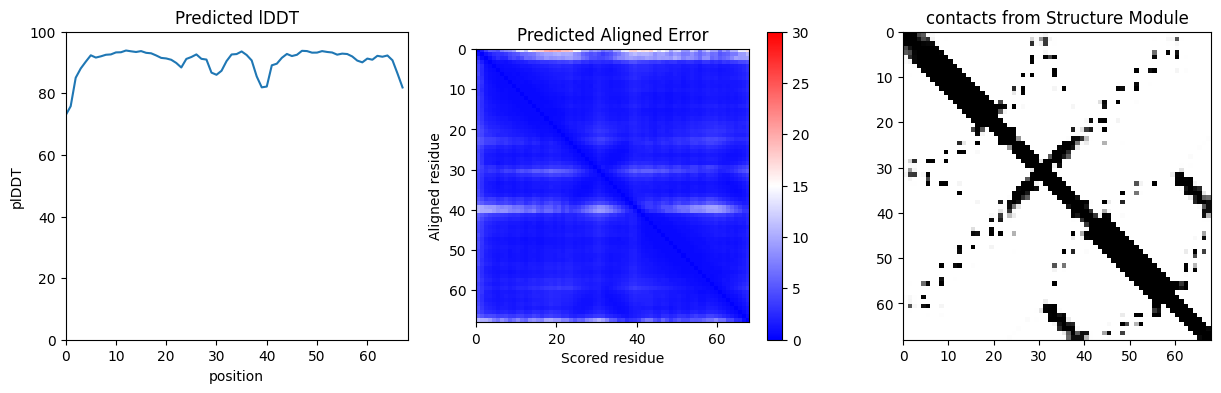

In [4]:
#@title plot confidence (optional)

dpi = 100 #@param {type:"integer"}

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

In [5]:
#@title download predictions
from google.colab import files
os.system(f"zip {ID}.zip {ID}/*")
files.download(f'{ID}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
%%time
# Install official ESM + ESMFold and utilities
!pip install -q "fair-esm[esmfold]" biotite

import math
import random
from pathlib import Path
from tempfile import NamedTemporaryFile

import numpy as np
import torch
import biotite.structure.io as bsio
import esm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 kB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.9 MB/s eta 0:00:00
CPU times: user 2.28 s, sys: 292 ms, total: 2.57 s
Wall time: 14.8 s


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#############################################
# Load ESM-2 (35M) sequence model
#############################################

lm_model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
lm_model = lm_model.to(device)
lm_model.eval()  # no backprop, ES is gradient-free

AA_LETTERS = list("ACDEFGHIKLMNPQRSTVWY")
AA_INDICES = torch.tensor([alphabet.get_idx(a) for a in AA_LETTERS], device=device)

mask_idx = alphabet.mask_idx
cls_idx  = alphabet.cls_idx
eos_idx  = alphabet.eos_idx

print("Loaded ESM-2 35M model.")

#############################################
# Load ESMFold structure model (black-box)
#############################################

fold_model = esm.pretrained.esmfold_v1()
fold_model = fold_model.eval().to(device)
fold_model.set_chunk_size(128)  # mildly more memory-efficient on Colab

print("Loaded ESMFold v1.")


Using device: cuda
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt
Loaded ESM-2 35M model.
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esmfold_3B_v1.pt" to /root/.cache/torch/hub/checkpoints/esmfold_3B_v1.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t36_3B_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t36_3B_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D-contact-regression.pt
Loaded ESMFold v1.


In [8]:
@torch.no_grad()
def sample_sequence_from_lm(
    model,
    alphabet,
    length=100,
    temperature=1.0,
    device=device,
):
    """
    Simple left-to-right generation using ESM-2 as a pseudo autoregressive LM.
    """
    total_len = length + 2  # [CLS] + L tokens + [EOS]
    tokens = torch.full((1, total_len), fill_value=mask_idx, device=device, dtype=torch.long)
    tokens[0, 0] = cls_idx
    tokens[0, -1] = eos_idx

    for pos in range(1, length + 1):
        tokens[0, pos] = mask_idx
        out = model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]  # (vocab_size,)

        # Restrict to the 20 standard amino acids
        aa_logits = logits[AA_INDICES]
        probs = torch.softmax(aa_logits / temperature, dim=-1)

        # Sample one amino acid
        aa_idx = torch.multinomial(probs, num_samples=1)
        tok_id = AA_INDICES[aa_idx]
        tokens[0, pos] = tok_id

    seq_tokens = tokens[0, 1:-1].tolist()
    seq = "".join(alphabet.get_tok(t) for t in seq_tokens)
    return seq


# Quick sanity check
test_seq = sample_sequence_from_lm(lm_model, alphabet, length=60, temperature=1.0)
print("Example generated sequence:", test_seq)
print("Length:", len(test_seq))

Example generated sequence: MAPAFLGFGMPLAQCPSPPGVPCCYPNAPDVPAPGTPIVVPEHFMDSCPFCQRLLMHLQG
Length: 60


In [9]:
@torch.no_grad()
def evaluate_sequence_with_esmfold(
    sequence: str,
    fold_model=fold_model,
    device=device,
) -> float:
    """
    Black-box reward: ESMFold structure prediction + mean pLDDT.
    """
    pdb_str = fold_model.infer_pdb(sequence)

    with NamedTemporaryFile("w+", suffix=".pdb") as tmp:
        tmp.write(pdb_str)
        tmp.flush()
        struct = bsio.load_structure(tmp.name, extra_fields=["b_factor"])

    mean_plddt = float(struct.b_factor.mean())
    return mean_plddt


def evaluate_model_once(
    num_sequences=3,
    seq_length=80,
    temperature=1.0,
):
    """
    For the *current* lm_model parameters, generate sequences,
    score each with ESMFold, and return the average score.
    """
    scores = []
    for _ in range(num_sequences):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        scores.append(score)
    return float(np.mean(scores)), scores

In [10]:
import torch.nn as nn

class EggrollContext:
    """
    Global context used by hooked Linear layers to decide
    whether to inject low-rank noise and which noise to use.
    """
    def __init__(self, device):
        self.active    = False  # enable/disable noise
        self.rank      = 0      # low-rank dimension r
        self.sigma     = 0.0    # noise scale
        self.thread_id = 0      # population member index
        self.device    = device

egg_ctx = EggrollContext(device)

# Hook all Linear layers in the ESM-2 model
lin_modules = []  # (name, module, base_key)

for name, module in lm_model.named_modules():
    if isinstance(module, nn.Linear):
        base_key = random.randint(0, 2**31 - 1)
        lin_modules.append((name, module, base_key))
        orig_forward = module.forward

        def make_forward(m, orig, base_key):
            def forward_with_low_rank(x, _orig=orig, _module=m, _base_key=base_key):
                # Base linear output
                out = _orig(x)
                if egg_ctx.active and _module.weight.ndim == 2:
                    weight = _module.weight
                    out_features, in_features = weight.shape

                    # Deterministic RNG for (layer, thread_id)
                    g = torch.Generator(device=egg_ctx.device)
                    combined_seed = (_base_key ^ egg_ctx.thread_id) & 0x7FFFFFFF
                    g.manual_seed(combined_seed)

                    r = egg_ctx.rank
                    if r > 0:
                        perturb = torch.randn(
                            in_features + out_features,
                            r,
                            generator=g,
                            device=egg_ctx.device,
                        )
                        B = perturb[:in_features, :]      # (in, r)
                        A = perturb[in_features:, :]      # (out, r)

                        # LoRA-style adapter: x @ B -> (batch, r); then @ A^T -> (batch, out)
                        adapter = x @ B
                        adapter = adapter @ A.t()
                        out = out + egg_ctx.sigma * adapter / math.sqrt(r)

                return out
            return forward_with_low_rank

        module.forward = make_forward(module, orig_forward, base_key)

print(f"Hooked {len(lin_modules)} Linear modules for EGGROLL-style noise.")

Hooked 74 Linear modules for EGGROLL-style noise.


In [11]:
# Map parameter names to tensor objects
name_to_param = dict(lm_model.named_parameters())

# Track only the 2D Linear weight matrices that correspond to hooked modules
linear_weights = []  # (param_name, param_tensor, base_key)

for name, module, base_key in lin_modules:
    w_name = name + ".weight"
    if w_name in name_to_param:
        linear_weights.append((w_name, name_to_param[w_name], base_key))

print("Number of Linear weight matrices to optimize:", len(linear_weights))

Number of Linear weight matrices to optimize: 74


In [12]:
@torch.no_grad()
def accumulate_linear_grad_buffers(
    grad_buffers,
    linear_weights,
    rank,
    sigma,
    thread_id,
    device,
    weight,
):
    """
    Re-generate the low-rank noise for each Linear weight and accumulate
    weight * sigma * ΔW into grad_buffers[name].
    """
    for param_name, param, base_key in linear_weights:
        out_features, in_features = param.data.shape

        g = torch.Generator(device=device)
        combined_seed = (base_key ^ thread_id) & 0x7FFFFFFF
        g.manual_seed(combined_seed)

        perturb = torch.randn(
            in_features + out_features,
            rank,
            generator=g,
            device=device,
        )
        B = perturb[:in_features, :]     # (in, r)
        A = perturb[in_features:, :]     # (out, r)
        delta = (A @ B.t()) / math.sqrt(rank)  # (out, in)

        if param_name not in grad_buffers:
            grad_buffers[param_name] = torch.zeros_like(param.data)
        grad_buffers[param_name].add_(weight * sigma * delta)


@torch.no_grad()
def es_step_eggroll(
    lm_model,
    linear_weights,
    rank,
    sigma,
    pop_size,
    lr,
    device,
    eval_fn,
    num_sequences,
    seq_length,
    temperature,
):
    """
    One EGGROLL-style ES step:
      - Evaluate pop_size perturbations via low-rank LoRA-like forward
      - Compute normalized rewards
      - Reconstruct perturbations to form a full-rank update
    """
    rewards = []

    # 1) Evaluate each population member
    for j in range(pop_size):
        egg_ctx.active    = True
        egg_ctx.rank      = rank
        egg_ctx.sigma     = sigma
        egg_ctx.thread_id = j

        mean_score, _ = eval_fn(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )
        rewards.append(mean_score)

    # Turn off perturbations afterwards
    egg_ctx.active = False

    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)

    # 2) Normalize rewards (zero-mean, unit variance)
    if rewards_t.std() > 1e-8:
        norm_rewards = (rewards_t - rewards_t.mean()) / (rewards_t.std() + 1e-8)
    else:
        norm_rewards = rewards_t - rewards_t.mean()

    # 3) Accumulate gradient estimate in parameter space
    grad_buffers = {}
    for j, R in enumerate(norm_rewards):
        accumulate_linear_grad_buffers(
            grad_buffers,
            linear_weights,
            rank=rank,
            sigma=sigma,
            thread_id=j,
            device=device,
            weight=R.item(),
        )

    # 4) Apply update: θ_new = θ + lr * grad_estimate
    scale = lr / (pop_size * (sigma**2 + 1e-8))
    for param_name, param, base_key in linear_weights:
        param.data.add_(scale * grad_buffers[param_name])

    return float(rewards_t.mean().item()), float(rewards_t.max().item()), rewards

In [13]:
##########################################
# ES hyperparameters (Colab-friendly)
##########################################

SEQ_LENGTH      = 60       # amino acids per sequence
NUM_SEQUENCES   = 2        # sequences per population member
POP_SIZE        = 4        # ES population size
RANK            = 4        # low-rank dimension r
SIGMA           = 0.05     # noise scale
LR              = 0.1      # learning rate in parameter space
NUM_STEPS       = 3        # ES iterations (increase if GPU allows)
TEMPERATURE     = 1.0      # sampling temperature for LM

print("=== ES CONFIGURATION ===")
print(f"SEQ_LENGTH    = {SEQ_LENGTH}")
print(f"NUM_SEQUENCES = {NUM_SEQUENCES}")
print(f"POP_SIZE      = {POP_SIZE}")
print(f"RANK          = {RANK}")
print(f"SIGMA         = {SIGMA}")
print(f"LR            = {LR}")
print(f"NUM_STEPS     = {NUM_STEPS}")


def eval_fn(num_sequences=NUM_SEQUENCES, seq_length=SEQ_LENGTH, temperature=TEMPERATURE):
    return evaluate_model_once(
        num_sequences=num_sequences,
        seq_length=seq_length,
        temperature=temperature,
    )


##########################################
# Run ES
##########################################

history = []

for step in range(1, NUM_STEPS + 1):
    avg_reward, max_reward, all_rewards = es_step_eggroll(
        lm_model,
        linear_weights,
        rank=RANK,
        sigma=SIGMA,
        pop_size=POP_SIZE,
        lr=LR,
        device=device,
        eval_fn=eval_fn,
        num_sequences=NUM_SEQUENCES,
        seq_length=SEQ_LENGTH,
        temperature=TEMPERATURE,
    )
    history.append((avg_reward, max_reward))
    print(f"[Step {step}] avg reward = {avg_reward:.2f}, max reward = {max_reward:.2f}")

=== ES CONFIGURATION ===
SEQ_LENGTH    = 60
NUM_SEQUENCES = 2
POP_SIZE      = 4
RANK          = 4
SIGMA         = 0.05
LR            = 0.1
NUM_STEPS     = 3
[Step 1] avg reward = 49.89, max reward = 55.47
[Step 2] avg reward = 51.05, max reward = 54.07
[Step 3] avg reward = 37.15, max reward = 40.93


In [14]:
@torch.no_grad()
def sample_and_score_n(n=3, length=SEQ_LENGTH):
    seqs = []
    scores = []
    for _ in range(n):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=length,
            temperature=TEMPERATURE,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        seqs.append(seq)
        scores.append(score)
    return seqs, scores


print("\nSampling sequences from the (possibly optimized) model...")
final_seqs, final_scores = sample_and_score_n(n=3, length=SEQ_LENGTH)

for i, (s, sc) in enumerate(zip(final_seqs, final_scores), 1):
    print(f"\nSequence {i} (mean pLDDT {sc:.2f}):\n{s}")


Sampling sequences from the (possibly optimized) model...

Sequence 1 (mean pLDDT 68.14):
KQLASSKRLKRSAAAFQHVVLFHLRQSLESKNTSVGDGDFFALFDLLLAGFLSILALLRL

Sequence 2 (mean pLDDT 52.01):
LRTSLFKRASLSQGRLTRRDTVHFLTEAFNSLGRTQSSAKLTLRLLSMFRFATAAAGQFS

Sequence 3 (mean pLDDT 68.32):
LELTRRYADCLGLLQTKLGSALRAIPTDALLLMLQLALSASVFAFSEPDCLFDLGDQFCI


In [15]:
%%time
import numpy as np

##########################################
# 1) Measure a proper baseline
##########################################

# We'll use the same length we train on
TRAIN_SEQ_LENGTH = 60

baseline_mean, baseline_scores = evaluate_model_once(
    num_sequences=10,
    seq_length=TRAIN_SEQ_LENGTH,
    temperature=1.0,
)
print(f"[Baseline] mean pLDDT over 10 sequences: {baseline_mean:.2f}")
print("Individual scores:", [f"{s:.2f}" for s in baseline_scores])

##########################################
# 2) New ES hyperparameters (more stable)
##########################################

TRAIN_NUM_SEQUENCES = 4   # more sequences per member → less noisy rewards
TRAIN_POP_SIZE      = 8   # larger population if GPU allows
TRAIN_RANK          = 4   # low-rank dimension (keep small for Colab)
TRAIN_SIGMA         = 0.02
TRAIN_LR            = 0.03
TRAIN_NUM_STEPS     = 20  # more ES iterations
TRAIN_TEMPERATURE   = 1.0

print("\n=== NEW ES CONFIGURATION ===")
print(f"TRAIN_SEQ_LENGTH    = {TRAIN_SEQ_LENGTH}")
print(f"TRAIN_NUM_SEQUENCES = {TRAIN_NUM_SEQUENCES}")
print(f"TRAIN_POP_SIZE      = {TRAIN_POP_SIZE}")
print(f"TRAIN_RANK          = {TRAIN_RANK}")
print(f"TRAIN_SIGMA         = {TRAIN_SIGMA}")
print(f"TRAIN_LR            = {TRAIN_LR}")
print(f"TRAIN_NUM_STEPS     = {TRAIN_NUM_STEPS}")

##########################################
# 3) Restrict which layers we mutate
##########################################
# Instead of updating all 74 Linear weights, we only update the last few.
# This often stabilizes training and keeps the model closer to its pretrained prior.

NUM_LINEAR_TO_TRAIN = 24  # you can change this (e.g., 16, 32, etc.)

if len(linear_weights) <= NUM_LINEAR_TO_TRAIN:
    trained_linear_weights = linear_weights
    print(f"\nTraining ALL {len(trained_linear_weights)} Linear weights.")
else:
    trained_linear_weights = linear_weights[-NUM_LINEAR_TO_TRAIN:]
    print(f"\nTraining ONLY the last {NUM_LINEAR_TO_TRAIN} Linear weights out of {len(linear_weights)} total.")

# Small helper so es_step_eggroll can call evaluate_model_once with named args
def train_eval_fn(num_sequences, seq_length, temperature):
    return evaluate_model_once(
        num_sequences=num_sequences,
        seq_length=seq_length,
        temperature=temperature,
    )


[Baseline] mean pLDDT over 10 sequences: 50.70
Individual scores: ['60.62', '60.99', '38.36', '36.65', '54.08', '47.14', '47.93', '53.28', '64.16', '43.75']

=== NEW ES CONFIGURATION ===
TRAIN_SEQ_LENGTH    = 60
TRAIN_NUM_SEQUENCES = 4
TRAIN_POP_SIZE      = 8
TRAIN_RANK          = 4
TRAIN_SIGMA         = 0.02
TRAIN_LR            = 0.03
TRAIN_NUM_STEPS     = 20

Training ONLY the last 24 Linear weights out of 74 total.
CPU times: user 22.8 s, sys: 0 ns, total: 22.8 s
Wall time: 22.8 s


In [16]:
%%time
history = []  # list of (avg_reward, max_reward)

print("\n=== Starting ES training ===")
for step in range(1, TRAIN_NUM_STEPS + 1):
    avg_reward, max_reward, all_rewards = es_step_eggroll(
        lm_model,
        trained_linear_weights,      # <--- restricted subset
        rank=TRAIN_RANK,
        sigma=TRAIN_SIGMA,
        pop_size=TRAIN_POP_SIZE,
        lr=TRAIN_LR,
        device=device,
        eval_fn=train_eval_fn,
        num_sequences=TRAIN_NUM_SEQUENCES,
        seq_length=TRAIN_SEQ_LENGTH,
        temperature=TRAIN_TEMPERATURE,
    )
    history.append((avg_reward, max_reward))
    print(
        f"[Step {step:02d}] "
        f"avg reward = {avg_reward:.2f}, "
        f"max reward = {max_reward:.2f}, "
        f"pop rewards = {[f'{r:.2f}' for r in all_rewards]}"
    )

##########################################
# Post-training evaluation (same as baseline)
##########################################
post_mean, post_scores = evaluate_model_once(
    num_sequences=10,
    seq_length=TRAIN_SEQ_LENGTH,
    temperature=1.0,
)
print("\n=== Baseline vs Post-training ===")
print(f"Baseline mean pLDDT over 10 seqs: {baseline_mean:.2f}")
print(f"Post-train mean pLDDT over 10 seqs: {post_mean:.2f}")
print("Post-train individual scores:", [f"{s:.2f}" for s in post_scores])



=== Starting ES training ===
[Step 01] avg reward = 50.13, max reward = 57.53, pop rewards = ['50.58', '57.53', '46.49', '40.16', '46.31', '56.03', '49.34', '54.60']
[Step 02] avg reward = 55.95, max reward = 62.84, pop rewards = ['49.80', '59.96', '62.84', '48.39', '57.74', '59.19', '54.72', '54.94']
[Step 03] avg reward = 57.34, max reward = 63.08, pop rewards = ['60.22', '54.40', '63.08', '62.77', '45.73', '56.45', '57.15', '58.92']
[Step 04] avg reward = 49.43, max reward = 53.13, pop rewards = ['51.12', '50.89', '44.35', '48.39', '50.33', '49.32', '53.13', '47.91']
[Step 05] avg reward = 57.30, max reward = 62.07, pop rewards = ['59.26', '58.13', '49.84', '59.82', '62.07', '56.14', '60.08', '53.03']
[Step 06] avg reward = 58.08, max reward = 62.31, pop rewards = ['61.45', '62.31', '60.97', '57.94', '50.22', '57.31', '56.84', '57.59']
[Step 07] avg reward = 58.25, max reward = 63.97, pop rewards = ['63.38', '53.73', '61.57', '63.97', '54.02', '59.19', '49.89', '60.23']
[Step 08] a

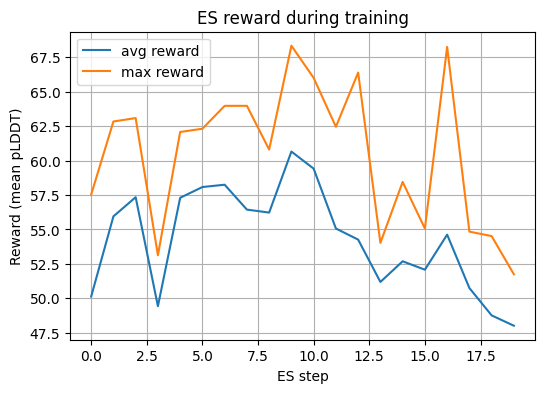


=== Sampling from final (ES-updated) model ===

Sequence 1 (mean pLDDT 61.71):
TAAEFLLGGARHLSFQTAAHLAQFARALLLLLAHCRLAAVAAAASHRAGPLAGHRAKAAF

Sequence 2 (mean pLDDT 55.75):
HLWARHKRASAHEVHTAHSLAASLAASLRGRGAAALSPAAAAADWAAASKPAGGGAKQAK

Sequence 3 (mean pLDDT 43.62):
PSSGDALCRSAKLRHRAFKINAVAAKAGAKPNKYSILSAHLQGAAHEDRRAKWAWAGSPA


In [17]:
import matplotlib.pyplot as plt

##########################################
# Plot avg and max reward vs training step
##########################################

avg_hist = [a for (a, m) in history]
max_hist = [m for (a, m) in history]

plt.figure(figsize=(6,4))
plt.plot(avg_hist, label="avg reward")
plt.plot(max_hist, label="max reward")
plt.xlabel("ES step")
plt.ylabel("Reward (mean pLDDT)")
plt.title("ES reward during training")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Sample and score a few sequences from the final model
##########################################

@torch.no_grad()
def sample_and_score_n(n=3, length=TRAIN_SEQ_LENGTH):
    seqs = []
    scores = []
    for _ in range(n):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=length,
            temperature=TRAIN_TEMPERATURE,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        seqs.append(seq)
        scores.append(score)
    return seqs, scores

print("\n=== Sampling from final (ES-updated) model ===")
final_seqs, final_scores = sample_and_score_n(n=3, length=TRAIN_SEQ_LENGTH)

for i, (s, sc) in enumerate(zip(final_seqs, final_scores), 1):
    print(f"\nSequence {i} (mean pLDDT {sc:.2f}):\n{s}")


In [18]:
%%time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

##########################################
# 1. CONFIG (edit these to trade off runtime vs robustness)
##########################################

N_EXPERIMENTS          = 3      # number of ES runs with different seeds (e.g. 3–5)
BASELINE_N_SEQS        = 30     # sequences for baseline evaluation (30–50 recommended)
POST_N_SEQS            = 30     # sequences for post-training evaluation
EVAL_SEQ_LENGTH        = 60
EVAL_TEMPERATURE       = 1.0

# ES training hyperparameters PER EXPERIMENT
TRAIN_SEQ_LENGTH       = 60
TRAIN_NUM_SEQUENCES    = 4      # sequences per population member per step
TRAIN_POP_SIZE         = 8      # population size (try 8–16 if GPU allows)
TRAIN_RANK             = 4      # low-rank dimension
TRAIN_SIGMA            = 0.02
TRAIN_LR               = 0.03
TRAIN_NUM_STEPS        = 15     # steps per experiment (30 is stronger but slower)
TRAIN_TEMPERATURE      = 1.0

# Which subset of linear layers to train (last K)
NUM_LINEAR_TO_TRAIN    = 24

print("=== MULTI-RUN CONFIG ===")
print(f"N_EXPERIMENTS         = {N_EXPERIMENTS}")
print(f"BASELINE_N_SEQS       = {BASELINE_N_SEQS}")
print(f"POST_N_SEQS           = {POST_N_SEQS}")
print(f"TRAIN_POP_SIZE        = {TRAIN_POP_SIZE}")
print(f"TRAIN_NUM_STEPS       = {TRAIN_NUM_STEPS}")
print(f"TRAIN_NUM_SEQUENCES   = {TRAIN_NUM_SEQUENCES}")
print(f"NUM_LINEAR_TO_TRAIN   = {NUM_LINEAR_TO_TRAIN}")

##########################################
# 2. Choose subset of linear weights to train
##########################################

if len(linear_weights) <= NUM_LINEAR_TO_TRAIN:
    trained_linear_weights_global = linear_weights
    print(f"\nTraining ALL {len(trained_linear_weights_global)} Linear weights.")
else:
    trained_linear_weights_global = linear_weights[-NUM_LINEAR_TO_TRAIN:]
    print(f"\nTraining ONLY the last {NUM_LINEAR_TO_TRAIN} Linear weights out of {len(linear_weights)} total.")

##########################################
# 3. Save a base copy of the model to reset each experiment
##########################################

base_state_dict = {k: v.detach().cpu().clone() for k, v in lm_model.state_dict().items()}
print("\nSaved base model state for resetting between experiments.")


##########################################
# 4. Helper: evaluate model distribution (mean, std, tails)
##########################################

@torch.no_grad()
def evaluate_model_distribution(
    n_sequences: int,
    seq_length: int,
    temperature: float,
):
    """
    Generate n_sequences from the *current* lm_model, score with ESMFold,
    and return a dict with mean, std, and tail fractions.
    """
    scores = []
    for _ in range(n_sequences):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        score = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
        scores.append(score)

    scores = np.array(scores, dtype=np.float32)
    mean_score = float(scores.mean())
    std_score  = float(scores.std(ddof=1)) if len(scores) > 1 else 0.0
    frac_gt_60 = float((scores > 60.0).mean())
    frac_lt_30 = float((scores < 30.0).mean())

    metrics = {
        "mean": mean_score,
        "std": std_score,
        "frac_gt_60": frac_gt_60,
        "frac_lt_30": frac_lt_30,
        "scores": scores,
    }
    return metrics


=== MULTI-RUN CONFIG ===
N_EXPERIMENTS         = 3
BASELINE_N_SEQS       = 30
POST_N_SEQS           = 30
TRAIN_POP_SIZE        = 8
TRAIN_NUM_STEPS       = 15
TRAIN_NUM_SEQUENCES   = 4
NUM_LINEAR_TO_TRAIN   = 24

Training ONLY the last 24 Linear weights out of 74 total.

Saved base model state for resetting between experiments.
CPU times: user 280 ms, sys: 265 µs, total: 281 ms
Wall time: 49.5 ms


In [19]:
%%time
import random

def run_es_experiment(exp_id: int, seed: int):
    """
    Run one ES experiment:
      1) Reset model to base_state_dict
      2) Evaluate baseline distribution
      3) Run ES training
      4) Evaluate post-training distribution
    Returns a dict with baseline + post metrics and training history.
    """
    print(f"\n====================")
    print(f"Starting experiment {exp_id} with seed {seed}")
    print(f"====================")

    # --- Set seeds for reproducibility ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # --- Reset model to base state ---
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # --- Evaluate baseline distribution ---
    baseline_metrics = evaluate_model_distribution(
        n_sequences=BASELINE_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Baseline mean pLDDT = {baseline_metrics['mean']:.2f} "
        f"+/- {baseline_metrics['std']:.2f}, "
        f"frac>60 = {baseline_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {baseline_metrics['frac_lt_30']:.2f}"
    )

    # --- ES training loop ---
    history = []  # (avg_reward, max_reward)
    def train_eval_fn(num_sequences, seq_length, temperature):
        return evaluate_model_once(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )

    for step in range(1, TRAIN_NUM_STEPS + 1):
        avg_reward, max_reward, all_rewards = es_step_eggroll(
            lm_model,
            trained_linear_weights_global,
            rank=TRAIN_RANK,
            sigma=TRAIN_SIGMA,
            pop_size=TRAIN_POP_SIZE,
            lr=TRAIN_LR,
            device=device,
            eval_fn=train_eval_fn,
            num_sequences=TRAIN_NUM_SEQUENCES,
            seq_length=TRAIN_SEQ_LENGTH,
            temperature=TRAIN_TEMPERATURE,
        )
        history.append((avg_reward, max_reward))
        print(
            f"[Exp {exp_id} | Step {step:02d}] "
            f"avg = {avg_reward:.2f}, max = {max_reward:.2f}"
        )

    # --- Evaluate post-training distribution ---
    post_metrics = evaluate_model_distribution(
        n_sequences=POST_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Post-train mean pLDDT = {post_metrics['mean']:.2f} "
        f"+/- {post_metrics['std']:.2f}, "
        f"frac>60 = {post_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {post_metrics['frac_lt_30']:.2f}"
    )

    return {
        "exp_id": exp_id,
        "seed": seed,
        "baseline": baseline_metrics,
        "post": post_metrics,
        "history": history,
    }


##########################################
# Run multiple experiments with different seeds
##########################################

experiment_results = []

base_seed = 12345  # change this if you like
for i in range(N_EXPERIMENTS):
    seed = base_seed + i
    res = run_es_experiment(exp_id=i, seed=seed)
    experiment_results.append(res)

print("\n=== Finished all experiments ===")



Starting experiment 0 with seed 12345
[Exp 0] Baseline mean pLDDT = 51.51 +/- 10.28, frac>60 = 0.13, frac<30 = 0.00
[Exp 0 | Step 01] avg = 48.45, max = 55.03
[Exp 0 | Step 02] avg = 49.88, max = 61.31
[Exp 0 | Step 03] avg = 48.91, max = 51.49
[Exp 0 | Step 04] avg = 52.19, max = 60.00
[Exp 0 | Step 05] avg = 49.22, max = 55.61
[Exp 0 | Step 06] avg = 46.25, max = 54.07
[Exp 0 | Step 07] avg = 49.99, max = 52.81
[Exp 0 | Step 08] avg = 48.23, max = 60.62
[Exp 0 | Step 09] avg = 45.68, max = 53.55
[Exp 0 | Step 10] avg = 50.26, max = 54.39
[Exp 0 | Step 11] avg = 46.58, max = 50.26
[Exp 0 | Step 12] avg = 52.76, max = 70.50
[Exp 0 | Step 13] avg = 50.51, max = 57.44
[Exp 0 | Step 14] avg = 54.71, max = 71.35
[Exp 0 | Step 15] avg = 54.81, max = 61.58
[Exp 0] Post-train mean pLDDT = 52.51 +/- 8.23, frac>60 = 0.17, frac<30 = 0.00

Starting experiment 1 with seed 12346
[Exp 1] Baseline mean pLDDT = 51.32 +/- 8.89, frac>60 = 0.10, frac<30 = 0.00
[Exp 1 | Step 01] avg = 49.51, max = 58.29


=== Aggregate over experiments ===
Baseline mean pLDDT: 50.35 +/- 1.85
Post-train mean pLDDT: 51.33 +/- 8.03

Baseline frac>60: 0.11 +/- 0.02
Post-train  frac>60: 0.21 +/- 0.24

Baseline frac<30: 0.00 +/- 0.00
Post-train  frac<30: 0.00 +/- 0.00


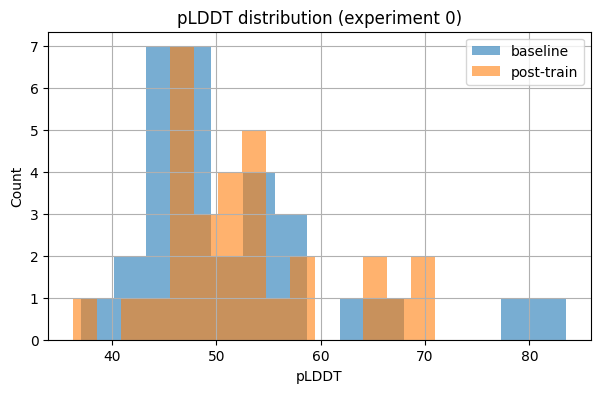

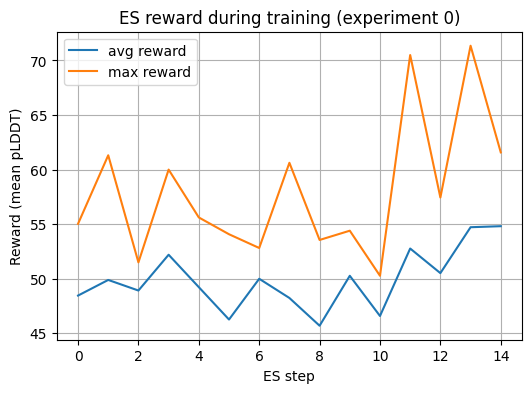

CPU times: user 290 ms, sys: 9.01 ms, total: 299 ms
Wall time: 300 ms


In [20]:
%%time
# Aggregate baseline vs post across experiments

baseline_means = [r["baseline"]["mean"] for r in experiment_results]
post_means     = [r["post"]["mean"] for r in experiment_results]

baseline_fracs_gt60 = [r["baseline"]["frac_gt_60"] for r in experiment_results]
post_fracs_gt60     = [r["post"]["frac_gt_60"] for r in experiment_results]

baseline_fracs_lt30 = [r["baseline"]["frac_lt_30"] for r in experiment_results]
post_fracs_lt30     = [r["post"]["frac_lt_30"] for r in experiment_results]

def summarize(arr):
    arr = np.array(arr, dtype=np.float32)
    return float(arr.mean()), float(arr.std(ddof=1) if len(arr) > 1 else 0.0)

b_mean, b_std = summarize(baseline_means)
p_mean, p_std = summarize(post_means)

b_gt60_mean, b_gt60_std = summarize(baseline_fracs_gt60)
p_gt60_mean, p_gt60_std = summarize(post_fracs_gt60)

b_lt30_mean, b_lt30_std = summarize(baseline_fracs_lt30)
p_lt30_mean, p_lt30_std = summarize(post_fracs_lt30)

print("=== Aggregate over experiments ===")
print(f"Baseline mean pLDDT: {b_mean:.2f} +/- {b_std:.2f}")
print(f"Post-train mean pLDDT: {p_mean:.2f} +/- {p_std:.2f}")
print()
print(f"Baseline frac>60: {b_gt60_mean:.2f} +/- {b_gt60_std:.2f}")
print(f"Post-train  frac>60: {p_gt60_mean:.2f} +/- {p_gt60_std:.2f}")
print()
print(f"Baseline frac<30: {b_lt30_mean:.2f} +/- {b_lt30_std:.2f}")
print(f"Post-train  frac<30: {p_lt30_mean:.2f} +/- {p_lt30_std:.2f}")

##########################################
# Optional: visualize distributions for one experiment
##########################################

exp_to_plot = 0  # index of experiment to inspect

baseline_scores = experiment_results[exp_to_plot]["baseline"]["scores"]
post_scores     = experiment_results[exp_to_plot]["post"]["scores"]

plt.figure(figsize=(7,4))
plt.hist(baseline_scores, bins=15, alpha=0.6, label="baseline")
plt.hist(post_scores, bins=15, alpha=0.6, label="post-train")
plt.xlabel("pLDDT")
plt.ylabel("Count")
plt.title(f"pLDDT distribution (experiment {exp_to_plot})")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Optional: plot ES reward curves for one experiment
##########################################

history0 = experiment_results[exp_to_plot]["history"]
avg_hist = [a for (a, m) in history0]
max_hist = [m for (a, m) in history0]

plt.figure(figsize=(6,4))
plt.plot(avg_hist, label="avg reward")
plt.plot(max_hist, label="max reward")
plt.xlabel("ES step")
plt.ylabel("Reward (mean pLDDT)")
plt.title(f"ES reward during training (experiment {exp_to_plot})")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
%%time
import copy
import random
import numpy as np
import torch

##########################################
# Early-stopping / checkpoint config
##########################################

ES_VALID_N_SEQS   = 10   # small validation sample size
ES_VALID_EVERY    = 2    # run validation every k ES steps
ES_PATIENCE       = 4    # stop if no improvement for this many validations
ES_MIN_STEPS      = 5    # always run at least this many steps before early stop

print("=== ES early-stopping CONFIG ===")
print(f"ES_VALID_N_SEQS = {ES_VALID_N_SEQS}")
print(f"ES_VALID_EVERY  = {ES_VALID_EVERY}")
print(f"ES_PATIENCE     = {ES_PATIENCE}")
print(f"ES_MIN_STEPS    = {ES_MIN_STEPS}")


def run_es_experiment_with_checkpoint(exp_id: int, seed: int):
    """
    ES experiment with:
      1) reset to base_state_dict
      2) baseline evaluation
      3) ES training with:
         - best-checkpoint tracking
         - optional early stopping
      4) post-training evaluation using BEST checkpoint
    Requires:
      - lm_model, device
      - base_state_dict
      - evaluate_model_distribution()
      - es_step_eggroll()
      - trained_linear_weights_global
      - TRAIN_* hyperparameters
    """
    print(f"\n====================")
    print(f"Starting ES experiment {exp_id} with seed {seed}")
    print(f"====================")

    # --- Set seeds for reproducibility ---
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # --- Reset model to base state ---
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # --- Evaluate baseline distribution ---
    baseline_metrics = evaluate_model_distribution(
        n_sequences=BASELINE_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Baseline mean pLDDT = {baseline_metrics['mean']:.2f} "
        f"+/- {baseline_metrics['std']:.2f}, "
        f"frac>60 = {baseline_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {baseline_metrics['frac_lt_30']:.2f}"
    )

    # --- ES training loop with best checkpoint ---
    history = []  # (avg_reward, max_reward)
    best_valid_mean = -1e9
    best_state_dict = None
    best_step = 0
    n_valid_calls = 0

    def train_eval_fn(num_sequences, seq_length, temperature):
        return evaluate_model_once(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )

    for step in range(1, TRAIN_NUM_STEPS + 1):
        avg_reward, max_reward, all_rewards = es_step_eggroll(
            lm_model,
            trained_linear_weights_global,
            rank=TRAIN_RANK,
            sigma=TRAIN_SIGMA,
            pop_size=TRAIN_POP_SIZE,
            lr=TRAIN_LR,
            device=device,
            eval_fn=train_eval_fn,
            num_sequences=TRAIN_NUM_SEQUENCES,
            seq_length=TRAIN_SEQ_LENGTH,
            temperature=TRAIN_TEMPERATURE,
        )
        history.append((avg_reward, max_reward))
        print(
            f"[Exp {exp_id} | Step {step:02d}] "
            f"avg = {avg_reward:.2f}, max = {max_reward:.2f}"
        )

        # ---- Validation + checkpointing ----
        do_valid = (step % ES_VALID_EVERY == 0) or (step == TRAIN_NUM_STEPS)
        if do_valid:
            n_valid_calls += 1
            valid_metrics = evaluate_model_distribution(
                n_sequences=ES_VALID_N_SEQS,
                seq_length=EVAL_SEQ_LENGTH,
                temperature=EVAL_TEMPERATURE,
            )
            valid_mean = valid_metrics["mean"]
            print(
                f"[Exp {exp_id} | Step {step:02d}] "
                f"VALID mean pLDDT = {valid_mean:.2f}"
            )

            # update best checkpoint
            if valid_mean > best_valid_mean:
                best_valid_mean = valid_mean
                best_state_dict = {
                    k: v.detach().cpu().clone() for k, v in lm_model.state_dict().items()
                }
                best_step = step
                print(
                    f"[Exp {exp_id}] New BEST checkpoint at step {step} "
                    f"(valid mean = {valid_mean:.2f})"
                )

            # early stopping: if we have run at least ES_MIN_STEPS and
            # no improvement for ES_PATIENCE validations
            if step >= ES_MIN_STEPS:
                steps_since_best = step - best_step
                # number of validations since best
                val_since_best = steps_since_best // ES_VALID_EVERY
                if val_since_best >= ES_PATIENCE:
                    print(
                        f"[Exp {exp_id}] Early stopping at step {step} "
                        f"(no improvement for {val_since_best} validations)."
                    )
                    break

    # If we never improved, fall back to final state
    if best_state_dict is None:
        print(f"[Exp {exp_id}] No improvement found; using final model.")
    else:
        print(
            f"[Exp {exp_id}] Loading BEST checkpoint from step {best_step} "
            f"(valid mean = {best_valid_mean:.2f})"
        )
        lm_model.load_state_dict(best_state_dict)
        lm_model.to(device)
        lm_model.eval()

    # --- Evaluate post-training distribution from BEST checkpoint ---
    post_metrics = evaluate_model_distribution(
        n_sequences=POST_N_SEQS,
        seq_length=EVAL_SEQ_LENGTH,
        temperature=EVAL_TEMPERATURE,
    )
    print(
        f"[Exp {exp_id}] Post-train mean pLDDT = {post_metrics['mean']:.2f} "
        f"+/- {post_metrics['std']:.2f}, "
        f"frac>60 = {post_metrics['frac_gt_60']:.2f}, "
        f"frac<30 = {post_metrics['frac_lt_30']:.2f}"
    )

    return {
        "exp_id": exp_id,
        "seed": seed,
        "baseline": baseline_metrics,
        "post": post_metrics,
        "history": history,
        "best_step": best_step,
        "best_valid_mean": best_valid_mean,
    }

=== ES early-stopping CONFIG ===
ES_VALID_N_SEQS = 10
ES_VALID_EVERY  = 2
ES_PATIENCE     = 4
ES_MIN_STEPS    = 5
CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 69.9 µs


In [22]:
%%time
experiment_results_es = []

base_seed = 12345
for i in range(N_EXPERIMENTS):
    seed = base_seed + i
    res = run_es_experiment_with_checkpoint(exp_id=i, seed=seed)
    experiment_results_es.append(res)

print("\n=== Finished ES experiments with checkpointing ===")


Starting ES experiment 0 with seed 12345
[Exp 0] Baseline mean pLDDT = 51.51 +/- 10.28, frac>60 = 0.13, frac<30 = 0.00
[Exp 0 | Step 01] avg = 48.45, max = 55.03
[Exp 0 | Step 02] avg = 49.88, max = 61.31
[Exp 0 | Step 02] VALID mean pLDDT = 52.02
[Exp 0] New BEST checkpoint at step 2 (valid mean = 52.02)
[Exp 0 | Step 03] avg = 49.29, max = 53.15
[Exp 0 | Step 04] avg = 47.22, max = 51.27
[Exp 0 | Step 04] VALID mean pLDDT = 46.26
[Exp 0 | Step 05] avg = 49.38, max = 55.35
[Exp 0 | Step 06] avg = 49.23, max = 55.13
[Exp 0 | Step 06] VALID mean pLDDT = 51.38
[Exp 0 | Step 07] avg = 46.40, max = 52.81
[Exp 0 | Step 08] avg = 47.19, max = 51.02
[Exp 0 | Step 08] VALID mean pLDDT = 44.38
[Exp 0 | Step 09] avg = 45.44, max = 48.08
[Exp 0 | Step 10] avg = 47.98, max = 53.20
[Exp 0 | Step 10] VALID mean pLDDT = 47.05
[Exp 0] Early stopping at step 10 (no improvement for 4 validations).
[Exp 0] Loading BEST checkpoint from step 2 (valid mean = 52.02)
[Exp 0] Post-train mean pLDDT = 48.41 +/-

In [23]:
%%time
import random
import numpy as np

##########################################
# Sequence-space evolution baseline config
##########################################

SEQ_EVO_POP_SIZE      = TRAIN_POP_SIZE * TRAIN_NUM_SEQUENCES  # roughly match ES
SEQ_EVO_N_GENERATIONS = TRAIN_NUM_STEPS                       # roughly match ES
SEQ_EVO_N_PARENTS     = max(4, SEQ_EVO_POP_SIZE // 4)         # top fraction as parents
SEQ_EVO_MUT_RATE      = 0.05   # per-position mutation probability
SEQ_EVO_SEQ_LENGTH    = TRAIN_SEQ_LENGTH
SEQ_EVO_TEMPERATURE   = TRAIN_TEMPERATURE

print("=== Sequence-space evolution CONFIG ===")
print(f"POP_SIZE      = {SEQ_EVO_POP_SIZE}")
print(f"N_GENERATIONS = {SEQ_EVO_N_GENERATIONS}")
print(f"N_PARENTS     = {SEQ_EVO_N_PARENTS}")
print(f"MUT_RATE      = {SEQ_EVO_MUT_RATE}")
print(f"SEQ_LENGTH    = {SEQ_EVO_SEQ_LENGTH}")


def mutate_sequence(seq: str, mut_rate: float) -> str:
    """
    Simple point-mutation operator on amino acid sequences.
    Each position mutates with probability mut_rate to a random AA (uniform).
    """
    global AA_LETTERS
    aa_list = list(seq)
    for i in range(len(aa_list)):
        if random.random() < mut_rate:
            aa_list[i] = random.choice(AA_LETTERS)
    return "".join(aa_list)


@torch.no_grad()
def sequence_space_evolution_baseline(
    pop_size: int,
    n_generations: int,
    n_parents: int,
    seq_length: int,
    temperature: float,
    mut_rate: float,
    seed: int = 0,
):
    """
    Generic sequence-space evolution baseline:
      - Initialize population from the *base* lm_model (base_state_dict)
      - For n_generations:
          * evaluate with ESMFold
          * select top n_parents
          * generate new population by mutating parents
      - Track history of (avg_score, max_score) and best sequence found.
    """
    print(f"\n=== Running sequence-space evolution baseline (seed={seed}) ===")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Ensure lm_model is in base state (fairness)
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # --- Initialize population from base LM ---
    population = []
    for _ in range(pop_size):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        population.append(seq)

    best_seq = None
    best_score = -1e9
    history = []  # (avg_score, max_score)

    for gen in range(n_generations):
        scores = []
        for seq in population:
            sc = evaluate_sequence_with_esmfold(
                seq, fold_model=fold_model, device=device
            )
            scores.append(sc)

        scores = np.array(scores, dtype=np.float32)
        avg_sc = float(scores.mean())
        max_sc = float(scores.max())
        history.append((avg_sc, max_sc))

        print(
            f"[SeqEvo | Gen {gen:02d}] "
            f"avg = {avg_sc:.2f}, max = {max_sc:.2f}"
        )

        # Update global best
        best_idx = int(scores.argmax())
        if max_sc > best_score:
            best_score = max_sc
            best_seq = population[best_idx]
            print(f"[SeqEvo] New best sequence with pLDDT = {best_score:.2f}")

        # Last generation: no need to create next population
        if gen == n_generations - 1:
            break

        # --- Select parents & generate next-generation population ---
        parent_indices = scores.argsort()[::-1][:n_parents]
        parents = [population[i] for i in parent_indices]

        new_population = []

        # Elitism: carry over the best parent unchanged
        new_population.append(parents[0])

        # Fill the rest with mutated children
        while len(new_population) < pop_size:
            parent = random.choice(parents)
            child = mutate_sequence(parent, mut_rate)
            new_population.append(child)

        population = new_population

    return {
        "history": history,
        "best_seq": best_seq,
        "best_score": best_score,
        "final_population": population,
    }

=== Sequence-space evolution CONFIG ===
POP_SIZE      = 32
N_GENERATIONS = 15
N_PARENTS     = 8
MUT_RATE      = 0.05
SEQ_LENGTH    = 60
CPU times: user 119 µs, sys: 0 ns, total: 119 µs
Wall time: 112 µs


In [24]:
%%time
seq_evo_result = sequence_space_evolution_baseline(
    pop_size=SEQ_EVO_POP_SIZE,
    n_generations=SEQ_EVO_N_GENERATIONS,
    n_parents=SEQ_EVO_N_PARENTS,
    seq_length=SEQ_EVO_SEQ_LENGTH,
    temperature=SEQ_EVO_TEMPERATURE,
    mut_rate=SEQ_EVO_MUT_RATE,
    seed=999,
)

print("\n=== Sequence-space evolution summary ===")
print(f"Best pLDDT found: {seq_evo_result['best_score']:.2f}")
print(f"Best sequence:\n{seq_evo_result['best_seq']}")


=== Running sequence-space evolution baseline (seed=999) ===
[SeqEvo | Gen 00] avg = 50.80, max = 61.71
[SeqEvo] New best sequence with pLDDT = 61.71
[SeqEvo | Gen 01] avg = 56.36, max = 65.08
[SeqEvo] New best sequence with pLDDT = 65.08
[SeqEvo | Gen 02] avg = 60.66, max = 70.88
[SeqEvo] New best sequence with pLDDT = 70.88
[SeqEvo | Gen 03] avg = 60.34, max = 71.82
[SeqEvo] New best sequence with pLDDT = 71.82
[SeqEvo | Gen 04] avg = 64.92, max = 80.32
[SeqEvo] New best sequence with pLDDT = 80.32
[SeqEvo | Gen 05] avg = 71.12, max = 80.69
[SeqEvo] New best sequence with pLDDT = 80.69
[SeqEvo | Gen 06] avg = 69.60, max = 81.88
[SeqEvo] New best sequence with pLDDT = 81.88
[SeqEvo | Gen 07] avg = 72.69, max = 82.79
[SeqEvo] New best sequence with pLDDT = 82.79
[SeqEvo | Gen 08] avg = 72.71, max = 84.43
[SeqEvo] New best sequence with pLDDT = 84.43
[SeqEvo | Gen 09] avg = 76.23, max = 84.43
[SeqEvo | Gen 10] avg = 78.15, max = 85.51
[SeqEvo] New best sequence with pLDDT = 85.51
[SeqE

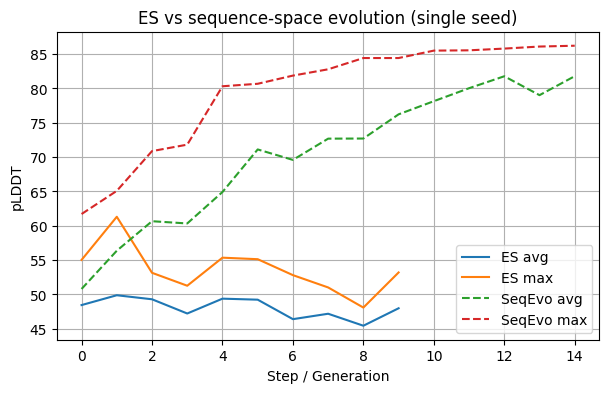

In [25]:
import matplotlib.pyplot as plt

# Example: compare ES experiment 0 vs sequence-space baseline
es_hist = experiment_results_es[0]["history"]  # (avg, max) per ES step
es_avg = [a for (a, m) in es_hist]
es_max = [m for (a, m) in es_hist]

seq_hist = seq_evo_result["history"]
seq_avg = [a for (a, m) in seq_hist]
seq_max = [m for (a, m) in seq_hist]

plt.figure(figsize=(7,4))
plt.plot(es_avg, label="ES avg")
plt.plot(es_max, label="ES max")
plt.plot(seq_avg, label="SeqEvo avg", linestyle="--")
plt.plot(seq_max, label="SeqEvo max", linestyle="--")
plt.xlabel("Step / Generation")
plt.ylabel("pLDDT")
plt.title("ES vs sequence-space evolution (single seed)")
plt.legend()
plt.grid(True)
plt.show()

Initialized ESMFold call counters.

=== Multi-objective small run CONFIG ===
ES: 1 exp, steps=5, pop=4
SeqEvo: 1 exp, gens=5, pop=8

Starting ES multi-objective experiment 0 (seed=2025)
[ES-Obj Exp 0 | Step 01] avg_reward=44.06, max_reward=46.32
[ES-Obj Exp 0 | Step 02] avg_reward=43.49, max_reward=49.18
[ES-Obj Exp 0 | Step 03] avg_reward=42.78, max_reward=43.74
[ES-Obj Exp 0 | Step 04] avg_reward=45.47, max_reward=57.72
[ES-Obj Exp 0 | Step 05] avg_reward=44.39, max_reward=51.03

=== SeqEvo multi-objective experiment 0 (seed=2125) ===
[SeqEvo-Obj Exp 0 | Gen 00] avg_reward=48.11, max_reward=66.78, avg_plddt=48.19
[SeqEvo-Obj Exp 0] New best: reward=66.78, pLDDT=66.86
[SeqEvo-Obj Exp 0 | Gen 01] avg_reward=58.95, max_reward=66.78, avg_plddt=59.03
[SeqEvo-Obj Exp 0 | Gen 02] avg_reward=64.55, max_reward=73.69, avg_plddt=64.63
[SeqEvo-Obj Exp 0] New best: reward=73.69, pLDDT=73.77
[SeqEvo-Obj Exp 0 | Gen 03] avg_reward=68.73, max_reward=73.69, avg_plddt=68.81
[SeqEvo-Obj Exp 0 | Gen 04]

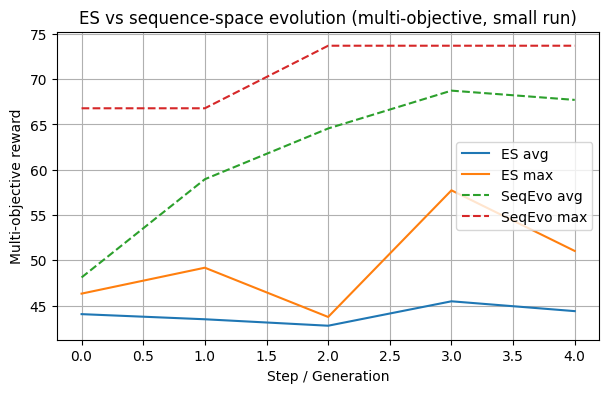

CPU times: user 6min 9s, sys: 112 ms, total: 6min 9s
Wall time: 6min 9s


In [29]:
%%time
"""
Post-ES utilities:
- Multi-objective reward (pLDDT + LM prior)
- ESMFold compute accounting for ES vs SeqEvo
- Multi-seed SeqEvo baseline
- Diversity analysis (sequence identity & entropy)
- Example small ES vs SeqEvo comparison using the new objective

This cell assumes you already defined:
  - lm_model, alphabet, AA_LETTERS, device
  - sample_sequence_from_lm(...)
  - evaluate_sequence_with_esmfold(...)
  - es_step_eggroll(...)
  - evaluate_model_distribution(...)
  - trained_linear_weights_global
  - base_state_dict
"""

import math
import numpy as np
import torch
import random
from collections import Counter

##########################################
# 1. Global counters for ESMFold calls
##########################################

ESMFOLD_CALLS_ES      = 0  # calls used by ES experiments
ESMFOLD_CALLS_SEQEVO  = 0  # calls used by SeqEvo experiments

def reset_esmfold_counters():
    global ESMFOLD_CALLS_ES, ESMFOLD_CALLS_SEQEVO
    ESMFOLD_CALLS_ES = 0
    ESMFOLD_CALLS_SEQEVO = 0

print("Initialized ESMFold call counters.")


##########################################
# 2. LM pseudo-likelihood (prior term)
##########################################

@torch.no_grad()
def lm_pseudo_log_prob_per_residue(seq: str) -> float:
    """
    Compute a (rough) pseudo log-likelihood per residue for a sequence under ESM-2.

    ESM-2 is a masked LM, so we approximate:
      log p(x) ≈ sum_i log p(x_i | x_{-i})
    by masking one position at a time and reading off the probability of the
    true amino acid.

    Returns natural-log average per residue (higher is better).
    """
    tokens = torch.full(
        (1, len(seq) + 2),
        fill_value=alphabet.mask_idx,
        device=device,
        dtype=torch.long,
    )
    tokens[0, 0] = alphabet.cls_idx
    tokens[0, -1] = alphabet.eos_idx
    # fill true sequence
    for i, aa in enumerate(seq, start=1):
        tokens[0, i] = alphabet.get_idx(aa)

    log_probs = []
    for pos in range(1, len(seq) + 1):
        orig = tokens[0, pos].item()
        tokens[0, pos] = alphabet.mask_idx
        out = lm_model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]  # vocab
        logp = torch.log_softmax(logits, dim=-1)[orig]
        log_probs.append(float(logp))
        tokens[0, pos] = orig

    return float(np.mean(log_probs))


##########################################
# 3. Multi-objective reward
##########################################

def compute_multiobjective_reward(
    seq: str,
    weight_lm_prior: float = 0.1,
    caller: str = "ES",
):
    """
    Composite reward:
        R(seq) = pLDDT(seq)  + weight_lm_prior * normalized_LM_prior(seq)

    where normalized_LM_prior is log p(x) / log(1/20) so that a uniform model ~0
    and a better-than-random model >0.

    caller: "ES" or "SEQEVO" -> used to increment correct ESMFold counter.
    """
    global ESMFOLD_CALLS_ES, ESMFOLD_CALLS_SEQEVO

    # 1) structural term: mean pLDDT from ESMFold
    plddt = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)

    if caller.upper() == "ES":
        ESMFOLD_CALLS_ES += 1
    elif caller.upper() == "SEQEVO":
        ESMFOLD_CALLS_SEQEVO += 1

    # 2) LM prior term
    lm_logp = lm_pseudo_log_prob_per_residue(seq)
    # normalize vs uniform AA distribution: log(1/20) = -log(20)
    norm_lm = lm_logp / (-math.log(1.0 / 20.0) + 1e-8)

    reward = float(plddt + weight_lm_prior * norm_lm)

    return reward, plddt, lm_logp, norm_lm


##########################################
# 4. ES training with the new objective & compute tracking
##########################################

def evaluate_model_once_objective(
    num_sequences: int,
    seq_length: int,
    temperature: float,
    weight_lm_prior: float = 0.1,
):
    """
    For current parameter setting of lm_model, generate num_sequences sequences,
    evaluate composite reward for each, and return (avg_reward, list_rewards).
    """
    rewards = []
    for _ in range(num_sequences):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        r, plddt, lm_logp, norm_lm = compute_multiobjective_reward(
            seq,
            weight_lm_prior=weight_lm_prior,
            caller="ES",
        )
        rewards.append(r)
    return float(np.mean(rewards)), rewards


def run_es_multiobjective_experiment(
    exp_id: int,
    seed: int,
    train_steps: int,
    train_pop_size: int,
    train_num_sequences: int,
    train_seq_length: int,
    train_temperature: float,
    train_sigma: float,
    train_lr: float,
    weight_lm_prior: float = 0.1,
):
    """
    Single ES experiment with the new composite objective.
    Uses the existing es_step_eggroll but plugs in evaluate_model_once_objective.
    """
    print(f"\n====================")
    print(f"Starting ES multi-objective experiment {exp_id} (seed={seed})")
    print(f"====================")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # reset model to base state
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    history = []

    def train_eval_fn(num_sequences, seq_length, temperature):
        return evaluate_model_once_objective(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
            weight_lm_prior=weight_lm_prior,
        )

    for step in range(1, train_steps + 1):
        avg_reward, max_reward, all_rewards = es_step_eggroll(
            lm_model,
            trained_linear_weights_global,
            rank=TRAIN_RANK,
            sigma=train_sigma,
            pop_size=train_pop_size,
            lr=train_lr,
            device=device,
            eval_fn=train_eval_fn,
            num_sequences=train_num_sequences,
            seq_length=train_seq_length,
            temperature=train_temperature,
        )
        history.append((avg_reward, max_reward))
        print(
            f"[ES-Obj Exp {exp_id} | Step {step:02d}] "
            f"avg_reward={avg_reward:.2f}, max_reward={max_reward:.2f}"
        )

    # after training, sample some sequences and measure pLDDT & LM prior separately
    eval_metrics = evaluate_model_distribution(
        n_sequences=30,
        seq_length=train_seq_length,
        temperature=train_temperature,
    )

    return {
        "exp_id": exp_id,
        "seed": seed,
        "history": history,
        "eval_metrics": eval_metrics,
    }


##########################################
# 5. SeqEvo baseline with the same objective & compute tracking
##########################################

def mutate_sequence_with_mask(seq: str, mut_rate: float, mutable_mask=None) -> str:
    """
    Point mutation with optional mask:
      - If mutable_mask is None: any position can mutate.
      - Else: only positions with mutable_mask[i] == True can mutate.
    """
    global AA_LETTERS
    aa_list = list(seq)
    L = len(aa_list)
    if mutable_mask is None:
        mutable_mask = [True] * L

    for i in range(L):
        if not mutable_mask[i]:
            continue
        if random.random() < mut_rate:
            aa_list[i] = random.choice(AA_LETTERS)
    return "".join(aa_list)


@torch.no_grad()
def sequence_space_evolution_objective(
    exp_id: int,
    seed: int,
    pop_size: int,
    n_generations: int,
    n_parents: int,
    seq_length: int,
    temperature: float,
    mut_rate: float,
    weight_lm_prior: float = 0.1,
    mutable_mask=None,
):
    """
    SeqEvo baseline using the same composite reward as ES.

    mutable_mask: optional list[bool] of length seq_length;
                  False positions are frozen (scaffold), only others mutate.
    """
    print(f"\n=== SeqEvo multi-objective experiment {exp_id} (seed={seed}) ===")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # ensure base LM (for fairness)
    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # Initialize population
    population = []
    for _ in range(pop_size):
        seq = sample_sequence_from_lm(
            lm_model,
            alphabet,
            length=seq_length,
            temperature=temperature,
            device=device,
        )
        population.append(seq)

    best_seq = None
    best_reward = -1e9
    best_plddt = -1e9
    history = []

    for gen in range(n_generations):
        rewards = []
        plddts = []
        for seq in population:
            r, plddt, lm_logp, norm_lm = compute_multiobjective_reward(
                seq,
                weight_lm_prior=weight_lm_prior,
                caller="SEQEVO",
            )
            rewards.append(r)
            plddts.append(plddt)

        rewards = np.array(rewards, dtype=np.float32)
        plddts = np.array(plddts, dtype=np.float32)

        avg_r = float(rewards.mean())
        max_r = float(rewards.max())
        history.append((avg_r, max_r))

        print(
            f"[SeqEvo-Obj Exp {exp_id} | Gen {gen:02d}] "
            f"avg_reward={avg_r:.2f}, max_reward={max_r:.2f}, "
            f"avg_plddt={float(plddts.mean()):.2f}"
        )

        # update best
        idx_best = int(rewards.argmax())
        if rewards[idx_best] > best_reward:
            best_reward = float(rewards[idx_best])
            best_plddt = float(plddts[idx_best])
            best_seq = population[idx_best]
            print(
                f"[SeqEvo-Obj Exp {exp_id}] New best: "
                f"reward={best_reward:.2f}, pLDDT={best_plddt:.2f}"
            )

        if gen == n_generations - 1:
            break

        # parent selection
        parent_indices = rewards.argsort()[::-1][:n_parents]
        parents = [population[i] for i in parent_indices]

        new_population = []
        # elitism
        new_population.append(parents[0])

        while len(new_population) < pop_size:
            parent = random.choice(parents)
            child = mutate_sequence_with_mask(parent, mut_rate, mutable_mask)
            new_population.append(child)

        population = new_population

    return {
        "exp_id": exp_id,
        "seed": seed,
        "history": history,
        "best_seq": best_seq,
        "best_reward": best_reward,
        "best_plddt": best_plddt,
        "final_population": population,
    }


##########################################
# 6. Diversity analysis
##########################################

def sequence_identity(s1: str, s2: str) -> float:
    """Fraction of identical positions between two equal-length sequences."""
    assert len(s1) == len(s2)
    same = sum(a == b for a, b in zip(s1, s2))
    return same / len(s1)


def analyze_sequence_set(seqs, label="set"):
    """
    Compute simple diversity metrics:
      - mean pairwise identity
      - per-position entropy
    """
    if len(seqs) == 0:
        print(f"[Diversity] {label}: no sequences.")
        return {}

    L = len(seqs[0])
    seqs = [s for s in seqs if len(s) == L]
    n = len(seqs)

    # pairwise identities
    if n > 1:
        ids = []
        for i in range(n):
            for j in range(i + 1, n):
                ids.append(sequence_identity(seqs[i], seqs[j]))
        mean_id = float(np.mean(ids))
    else:
        mean_id = float("nan")

    # per-position entropy
    entropies = []
    for pos in range(L):
        column = [s[pos] for s in seqs]
        counts = Counter(column)
        total = sum(counts.values())
        probs = np.array([c / total for c in counts.values()], dtype=np.float32)
        ent = -float((probs * np.log2(probs + 1e-12)).sum())
        entropies.append(ent)

    mean_entropy = float(np.mean(entropies))

    print(
        f"[Diversity] {label}: n={n}, "
        f"mean pairwise identity={mean_id:.3f}, "
        f"mean per-pos entropy={mean_entropy:.3f}"
    )

    return {
        "n": n,
        "mean_identity": mean_id,
        "mean_entropy": mean_entropy,
        "entropies": entropies,
    }


##########################################
# 7. Example small-scale ES vs SeqEvo objective run
##########################################

# You can scale these up later; these are modest so it doesn't explode compute.
OBJ_ES_N_EXPERIMENTS      = 1
OBJ_ES_TRAIN_STEPS        = 5
OBJ_ES_POP_SIZE           = 4
OBJ_ES_NUM_SEQUENCES      = 2
OBJ_ES_SEQ_LENGTH         = 60
OBJ_ES_TEMPERATURE        = 1.0
OBJ_ES_SIGMA              = TRAIN_SIGMA    # reuse your ES sigma
OBJ_ES_LR                 = TRAIN_LR       # reuse your ES lr
OBJ_WEIGHT_LM_PRIOR       = 0.1

OBJ_SEQEVO_N_EXPERIMENTS  = 1
OBJ_SEQEVO_POP_SIZE       = OBJ_ES_POP_SIZE * OBJ_ES_NUM_SEQUENCES
OBJ_SEQEVO_GENERATIONS    = OBJ_ES_TRAIN_STEPS
OBJ_SEQEVO_N_PARENTS      = max(4, OBJ_SEQEVO_POP_SIZE // 4)
OBJ_SEQEVO_MUT_RATE       = 0.05
OBJ_SEQEVO_SEQ_LENGTH     = OBJ_ES_SEQ_LENGTH
OBJ_SEQEVO_TEMPERATURE    = OBJ_ES_TEMPERATURE

print("\n=== Multi-objective small run CONFIG ===")
print(f"ES: {OBJ_ES_N_EXPERIMENTS} exp, steps={OBJ_ES_TRAIN_STEPS}, pop={OBJ_ES_POP_SIZE}")
print(f"SeqEvo: {OBJ_SEQEVO_N_EXPERIMENTS} exp, gens={OBJ_SEQEVO_GENERATIONS}, pop={OBJ_SEQEVO_POP_SIZE}")

reset_esmfold_counters()

# ---- Run ES multi-objective (small) ----
es_obj_results = []
base_seed = 2025
for i in range(OBJ_ES_N_EXPERIMENTS):
    res = run_es_multiobjective_experiment(
        exp_id=i,
        seed=base_seed + i,
        train_steps=OBJ_ES_TRAIN_STEPS,
        train_pop_size=OBJ_ES_POP_SIZE,
        train_num_sequences=OBJ_ES_NUM_SEQUENCES,
        train_seq_length=OBJ_ES_SEQ_LENGTH,
        train_temperature=OBJ_ES_TEMPERATURE,
        train_sigma=OBJ_ES_SIGMA,
        train_lr=OBJ_ES_LR,
        weight_lm_prior=OBJ_WEIGHT_LM_PRIOR,
    )
    es_obj_results.append(res)

# sample from final ES model of last experiment for diversity
es_sample_seqs = []
for _ in range(32):
    s = sample_sequence_from_lm(
        lm_model,
        alphabet,
        length=OBJ_ES_SEQ_LENGTH,
        temperature=OBJ_ES_TEMPERATURE,
        device=device,
    )
    es_sample_seqs.append(s)

# ---- Run SeqEvo multi-objective (small) ----
seqevo_obj_results = []
for i in range(OBJ_SEQEVO_N_EXPERIMENTS):
    res = sequence_space_evolution_objective(
        exp_id=i,
        seed=base_seed + 100 + i,
        pop_size=OBJ_SEQEVO_POP_SIZE,
        n_generations=OBJ_SEQEVO_GENERATIONS,
        n_parents=OBJ_SEQEVO_N_PARENTS,
        seq_length=OBJ_SEQEVO_SEQ_LENGTH,
        temperature=OBJ_SEQEVO_TEMPERATURE,
        mut_rate=OBJ_SEQEVO_MUT_RATE,
        weight_lm_prior=OBJ_WEIGHT_LM_PRIOR,
        mutable_mask=None,  # could freeze scaffold here
    )
    seqevo_obj_results.append(res)

seqevo_final_pop = seqevo_obj_results[0]["final_population"]

print("\n=== ESMFold compute summary ===")
print(f"ES ESMFold calls:      {ESMFOLD_CALLS_ES}")
print(f"SeqEvo ESMFold calls:  {ESMFOLD_CALLS_SEQEVO}")

# ---- Diversity comparison ----
div_es = analyze_sequence_set(es_sample_seqs, label="ES-final-samples")
div_seqevo = analyze_sequence_set(seqevo_final_pop, label="SeqEvo-final-population")

# ---- Simple plot of reward curves (single seed) ----
import matplotlib.pyplot as plt

es_hist = es_obj_results[0]["history"]
es_avg = [a for (a, m) in es_hist]
es_max = [m for (a, m) in es_hist]

seq_hist = seqevo_obj_results[0]["history"]
seq_avg = [a for (a, m) in seq_hist]
seq_max = [m for (a, m) in seq_hist]

plt.figure(figsize=(7,4))
plt.plot(es_avg, label="ES avg")
plt.plot(es_max, label="ES max")
plt.plot(seq_avg, label="SeqEvo avg", linestyle="--")
plt.plot(seq_max, label="SeqEvo max", linestyle="--")
plt.xlabel("Step / Generation")
plt.ylabel("Multi-objective reward")
plt.title("ES vs sequence-space evolution (multi-objective, small run)")
plt.legend()
plt.grid(True)
plt.show()


=== Constrained loop regime ===
Scaffold sequence (L=60):
MSGDSCHGGGWRAVVGGGWRRVLLLVVEVYVGGGYPNKDPQFSTMTTLQPMIVQDSPDDI
Mutable region: positions 20..39 (0-based)
Mutable mask (first 60 positions):
....................XXXXXXXXXXXXXXXXXXXX....................

=== Constrained multi-seed CONFIG ===
ES budget:    40 ESMFold calls (steps=5, pop=4, seq/worker=2)
SeqEvo budget:40 ESMFold calls (gens=5, pop=8)

ES constrained exp 0 (seed=3000)
[ES-constr Exp 0 | Step 01] avg=33.66, max=37.70
[ES-constr Exp 0 | Step 02] avg=35.11, max=37.73
[ES-constr Exp 0 | Step 03] avg=33.52, max=35.71
[ES-constr Exp 0 | Step 04] avg=35.00, max=37.18
[ES-constr Exp 0 | Step 05] avg=33.58, max=38.35
[Diversity] ES-exp0: n=32, mean pairwise identity=0.699, mean per-pos entropy=1.121

=== SeqEvo constrained exp 0 (seed=13000) ===
[SeqEvo-constr Exp 0 | Gen 00] avg=32.68, max=35.48, avg_pLDDT=35.38
[SeqEvo-constr Exp 0] New best: reward=35.48, pLDDT=38.23
[SeqEvo-constr Exp 0 | Gen 01] avg=34.24, max=35.48, avg

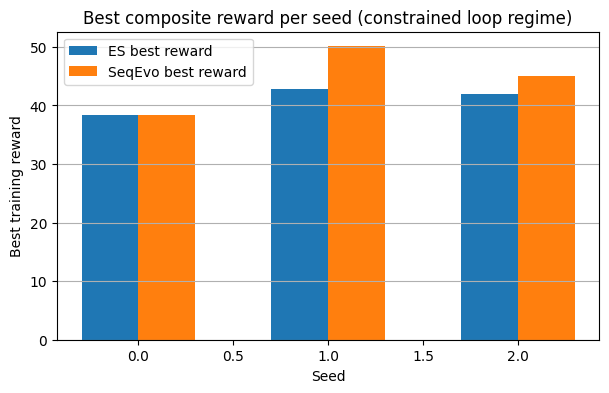

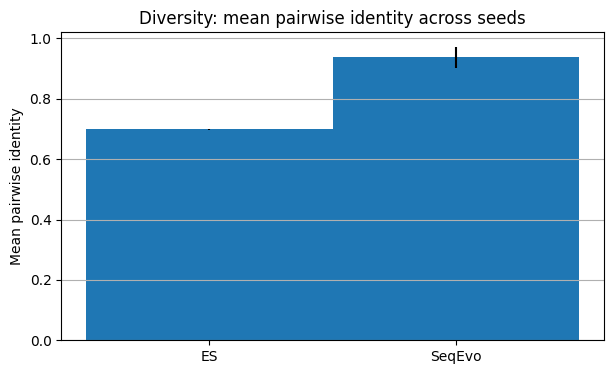

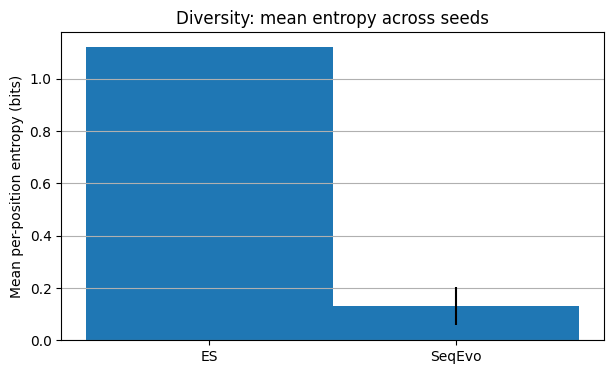

CPU times: user 12min 5s, sys: 240 ms, total: 12min 5s
Wall time: 12min 5s


In [30]:
%%time
"""
Constrained, multi-objective ES vs SeqEvo with multiple seeds.

Adds:
  - richer composite reward (pLDDT + LM prior - hydrophobic penalty)
  - constrained loop regime (fixed scaffold, mutable internal region)
  - multi-seed ES vs SeqEvo comparison with matched ESMFold training budget
  - summary of rewards and diversity across seeds

ASSUMES the previous cell has already defined:
  - lm_model, alphabet, AA_LETTERS, device
  - sample_sequence_from_lm(...)
  - evaluate_sequence_with_esmfold(...)
  - ESMFold call counters: ESMFOLD_CALLS_ES, ESMFOLD_CALLS_SEQEVO, reset_esmfold_counters()
  - diversity helpers: analyze_sequence_set(...)
  - ES machinery: es_step_eggroll(...), trained_linear_weights_global, TRAIN_RANK, TRAIN_SIGMA, TRAIN_LR
  - base_state_dict (saved initial LM weights)
"""

import math
import numpy as np
import torch
import random
from collections import Counter

##########################################
# 1. Updated multi-objective reward
##########################################

HYDROPHOBIC_AA = set("AILMFWVY")


def hydrophobic_fraction(seq: str) -> float:
    return sum(aa in HYDROPHOBIC_AA for aa in seq) / max(len(seq), 1)


@torch.no_grad()
def lm_pseudo_log_prob_per_residue(seq: str) -> float:
    """
    Pseudo log-likelihood per residue for a sequence under ESM-2.

    Same as in the previous cell, but repeated here to keep this block self-contained.
    """
    tokens = torch.full(
        (1, len(seq) + 2),
        fill_value=alphabet.mask_idx,
        device=device,
        dtype=torch.long,
    )
    tokens[0, 0] = alphabet.cls_idx
    tokens[0, -1] = alphabet.eos_idx
    for i, aa in enumerate(seq, start=1):
        tokens[0, i] = alphabet.get_idx(aa)

    log_probs = []
    for pos in range(1, len(seq) + 1):
        orig = tokens[0, pos].item()
        tokens[0, pos] = alphabet.mask_idx
        out = lm_model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]
        logp = torch.log_softmax(logits, dim=-1)[orig]
        log_probs.append(float(logp))
        tokens[0, pos] = orig

    return float(np.mean(log_probs))


def compute_multiobjective_reward(
    seq: str,
    weight_lm_prior: float = 0.1,
    target_hydro: float = 0.50,
    lambda_hydro: float = 20.0,
    caller: str = "ES",
):
    """
    Composite reward used for *both* ES and SeqEvo:

      R(seq) =
          pLDDT(seq)
        + weight_lm_prior * normalized_LM_prior(seq)
        - lambda_hydro * |hydrophobic_fraction(seq) - target_hydro|

    where normalized_LM_prior ≈ log p(x) / log(1/20), so that
    a uniform random model ≈ 0, better models > 0.

    We also increment global ESMFold call counters for compute accounting.
    """
    global ESMFOLD_CALLS_ES, ESMFOLD_CALLS_SEQEVO

    # 1) ESMFold term
    plddt = evaluate_sequence_with_esmfold(seq, fold_model=fold_model, device=device)
    if caller.upper() == "ES":
        ESMFOLD_CALLS_ES += 1
    elif caller.upper() == "SEQEVO":
        ESMFOLD_CALLS_SEQEVO += 1

    # 2) LM prior
    lm_logp = lm_pseudo_log_prob_per_residue(seq)
    norm_lm = lm_logp / (-math.log(1.0 / 20.0) + 1e-8)

    # 3) hydrophobicity penalty
    h = hydrophobic_fraction(seq)
    hydro_pen = lambda_hydro * abs(h - target_hydro)

    reward = float(plddt + weight_lm_prior * norm_lm - hydro_pen)
    return reward, plddt, lm_logp, norm_lm, h


##########################################
# 2. Constrained sequence generator (fixed scaffold, mutable loop)
##########################################

@torch.no_grad()
def sample_sequence_from_lm_constrained(
    model,
    alphabet,
    base_seq: str,
    mutable_mask,
    temperature: float = 1.0,
    device=device,
):
    """
    Sample a sequence of same length as base_seq, keeping positions with
    mutable_mask[i] == False fixed to base_seq[i], and resampling the others.

    Uses the same "mask a single position, run LM" trick as sample_sequence_from_lm.
    """
    L = len(base_seq)
    assert len(mutable_mask) == L

    tokens = torch.full(
        (1, L + 2),
        fill_value=alphabet.mask_idx,
        device=device,
        dtype=torch.long,
    )
    tokens[0, 0] = alphabet.cls_idx
    tokens[0, -1] = alphabet.eos_idx

    # initialize tokens to base_seq
    for i, aa in enumerate(base_seq, start=1):
        tokens[0, i] = alphabet.get_idx(aa)

    for pos in range(1, L + 1):
        if not mutable_mask[pos - 1]:
            # keep scaffold amino acid
            continue

        tokens[0, pos] = alphabet.mask_idx
        out = model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]

        aa_logits = logits[AA_INDICES]
        probs = torch.softmax(aa_logits / temperature, dim=-1)
        aa_idx = torch.multinomial(probs, num_samples=1)
        tok_id = AA_INDICES[aa_idx]
        tokens[0, pos] = tok_id

    seq_tokens = tokens[0, 1:-1].tolist()
    seq = "".join(alphabet.get_tok(t) for t in seq_tokens)
    return seq


##########################################
# 3. ES multi-objective experiment (with constraints)
##########################################

def evaluate_model_once_objective(
    num_sequences: int,
    seq_length: int,
    temperature: float,
    weight_lm_prior: float,
    target_hydro: float,
    lambda_hydro: float,
    base_seq: str = None,
    mutable_mask=None,
):
    rewards = []
    for _ in range(num_sequences):
        if base_seq is None or mutable_mask is None:
            seq = sample_sequence_from_lm(
                lm_model,
                alphabet,
                length=seq_length,
                temperature=temperature,
                device=device,
            )
        else:
            seq = sample_sequence_from_lm_constrained(
                lm_model,
                alphabet,
                base_seq=base_seq,
                mutable_mask=mutable_mask,
                temperature=temperature,
                device=device,
            )

        r, plddt, lm_logp, norm_lm, h = compute_multiobjective_reward(
            seq,
            weight_lm_prior=weight_lm_prior,
            target_hydro=target_hydro,
            lambda_hydro=lambda_hydro,
            caller="ES",
        )
        rewards.append(r)

    return float(np.mean(rewards)), rewards


def run_es_multiobjective_experiment_constrained(
    exp_id: int,
    seed: int,
    train_steps: int,
    train_pop_size: int,
    train_num_sequences: int,
    seq_length: int,
    temperature: float,
    sigma: float,
    lr: float,
    weight_lm_prior: float,
    target_hydro: float,
    lambda_hydro: float,
    base_seq: str,
    mutable_mask,
):
    """
    Same as run_es_multiobjective_experiment, but:
      - uses constrained sampling around base_seq with mutable_mask
      - returns best training reward + history
    """
    print(f"\n==============================")
    print(f"ES constrained exp {exp_id} (seed={seed})")
    print(f"==============================")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    history = []
    best_training_reward = -1e9

    def train_eval_fn(num_sequences, seq_length, temperature):
        avg_r, rewards = evaluate_model_once_objective(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
            weight_lm_prior=weight_lm_prior,
            target_hydro=target_hydro,
            lambda_hydro=lambda_hydro,
            base_seq=base_seq,
            mutable_mask=mutable_mask,
        )
        return avg_r, rewards

    for step in range(1, train_steps + 1):
        avg_reward, max_reward, all_rewards = es_step_eggroll(
            lm_model,
            trained_linear_weights_global,
            rank=TRAIN_RANK,
            sigma=sigma,
            pop_size=train_pop_size,
            lr=lr,
            device=device,
            eval_fn=train_eval_fn,
            num_sequences=train_num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )
        history.append((avg_reward, max_reward))
        best_training_reward = max(best_training_reward, max_reward)
        print(
            f"[ES-constr Exp {exp_id} | Step {step:02d}] "
            f"avg={avg_reward:.2f}, max={max_reward:.2f}"
        )

    # sample some sequences from final ES-tuned model for diversity analysis
    es_final_seqs = []
    for _ in range(32):
        s = sample_sequence_from_lm_constrained(
            lm_model,
            alphabet,
            base_seq=base_seq,
            mutable_mask=mutable_mask,
            temperature=temperature,
            device=device,
        )
        es_final_seqs.append(s)

    return {
        "exp_id": exp_id,
        "seed": seed,
        "history": history,
        "best_training_reward": best_training_reward,
        "final_seqs": es_final_seqs,
    }


##########################################
# 4. SeqEvo multi-objective, constrained
##########################################

def mutate_sequence_with_mask(seq: str, mut_rate: float, mutable_mask=None) -> str:
    aa_list = list(seq)
    L = len(aa_list)
    if mutable_mask is None:
        mutable_mask = [True] * L
    assert len(mutable_mask) == L

    for i in range(L):
        if not mutable_mask[i]:
            continue
        if random.random() < mut_rate:
            aa_list[i] = random.choice(AA_LETTERS)
    return "".join(aa_list)


def sequence_space_evolution_objective_constrained(
    exp_id: int,
    seed: int,
    pop_size: int,
    n_generations: int,
    n_parents: int,
    seq_length: int,
    temperature: float,
    mut_rate: float,
    weight_lm_prior: float,
    target_hydro: float,
    lambda_hydro: float,
    base_seq: str,
    mutable_mask,
):
    """
    SeqEvo baseline with:
      - composite reward (same as ES)
      - constrained mutations (only mutable_mask positions can change)
      - initial population generated by constrained LM sampling
    """
    print(f"\n=== SeqEvo constrained exp {exp_id} (seed={seed}) ===")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    lm_model.load_state_dict(base_state_dict)
    lm_model.to(device)
    lm_model.eval()

    # initial population
    population = []
    for _ in range(pop_size):
        s = sample_sequence_from_lm_constrained(
            lm_model,
            alphabet,
            base_seq=base_seq,
            mutable_mask=mutable_mask,
            temperature=temperature,
            device=device,
        )
        population.append(s)

    best_reward = -1e9
    best_plddt = -1e9
    best_seq = None
    history = []

    for gen in range(n_generations):
        rewards = []
        plddts = []
        for seq in population:
            r, plddt, lm_logp, norm_lm, h = compute_multiobjective_reward(
                seq,
                weight_lm_prior=weight_lm_prior,
                target_hydro=target_hydro,
                lambda_hydro=lambda_hydro,
                caller="SEQEVO",
            )
            rewards.append(r)
            plddts.append(plddt)

        rewards = np.array(rewards, dtype=np.float32)
        plddts = np.array(plddts, dtype=np.float32)

        avg_r = float(rewards.mean())
        max_r = float(rewards.max())
        history.append((avg_r, max_r))

        print(
            f"[SeqEvo-constr Exp {exp_id} | Gen {gen:02d}] "
            f"avg={avg_r:.2f}, max={max_r:.2f}, avg_pLDDT={float(plddts.mean()):.2f}"
        )

        idx_best = int(rewards.argmax())
        if rewards[idx_best] > best_reward:
            best_reward = float(rewards[idx_best])
            best_plddt = float(plddts[idx_best])
            best_seq = population[idx_best]
            print(
                f"[SeqEvo-constr Exp {exp_id}] "
                f"New best: reward={best_reward:.2f}, pLDDT={best_plddt:.2f}"
            )

        if gen == n_generations - 1:
            break

        parent_indices = rewards.argsort()[::-1][:n_parents]
        parents = [population[i] for i in parent_indices]

        new_population = [parents[0]]  # elitism
        while len(new_population) < pop_size:
            parent = random.choice(parents)
            child = mutate_sequence_with_mask(parent, mut_rate, mutable_mask)
            new_population.append(child)

        population = new_population

    return {
        "exp_id": exp_id,
        "seed": seed,
        "history": history,
        "best_reward": best_reward,
        "best_plddt": best_plddt,
        "best_seq": best_seq,
        "final_population": population,
    }


##########################################
# 5. Set up constrained loop regime
##########################################

# Choose a scaffold from the base LM (fixed seed for reproducibility)
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(777)

SCAFFOLD_LENGTH = 60
scaffold_seq = sample_sequence_from_lm(
    lm_model,
    alphabet,
    length=SCAFFOLD_LENGTH,
    temperature=1.0,
    device=device,
)

# Define central mutable loop: e.g., positions 20..39 (0-based)
loop_start = 20
loop_end = 40  # exclusive
mutable_mask = [False] * SCAFFOLD_LENGTH
for i in range(loop_start, loop_end):
    mutable_mask[i] = True

print("\n=== Constrained loop regime ===")
print(f"Scaffold sequence (L={SCAFFOLD_LENGTH}):")
print(scaffold_seq)
print(f"Mutable region: positions {loop_start}..{loop_end-1} (0-based)")
print("Mutable mask (first 60 positions):")
print("".join("X" if m else "." for m in mutable_mask))


##########################################
# 6. Multi-seed ES vs SeqEvo comparison
##########################################

N_SEEDS = 3  # bump this up when you have more compute

# Match total training ESMFold calls per seed:
# ES: steps * pop_size * num_sequences
CONSTR_ES_STEPS = 5
CONSTR_ES_POP = 4
CONSTR_ES_NUM_SEQ = 2
ES_BUDGET = CONSTR_ES_STEPS * CONSTR_ES_POP * CONSTR_ES_NUM_SEQ

# SeqEvo: generations * population size
CONSTR_SEQ_POP = 8
CONSTR_SEQ_GENS = 5
SEQ_BUDGET = CONSTR_SEQ_POP * CONSTR_SEQ_GENS

print("\n=== Constrained multi-seed CONFIG ===")
print(f"ES budget:    {ES_BUDGET} ESMFold calls (steps={CONSTR_ES_STEPS}, pop={CONSTR_ES_POP}, seq/worker={CONSTR_ES_NUM_SEQ})")
print(f"SeqEvo budget:{SEQ_BUDGET} ESMFold calls (gens={CONSTR_SEQ_GENS}, pop={CONSTR_SEQ_POP})")

# Composite objective weights
WEIGHT_LM_PRIOR = 0.1
TARGET_HYDRO = 0.50
LAMBDA_HYDRO = 20.0

es_results_all = []
seqevo_results_all = []
es_div_all = []
seq_div_all = []

reset_esmfold_counters()

base_seed = 3000

for i in range(N_SEEDS):
    seed = base_seed + i

    # --- ES ---
    es_res = run_es_multiobjective_experiment_constrained(
        exp_id=i,
        seed=seed,
        train_steps=CONSTR_ES_STEPS,
        train_pop_size=CONSTR_ES_POP,
        train_num_sequences=CONSTR_ES_NUM_SEQ,
        seq_length=SCAFFOLD_LENGTH,
        temperature=1.0,
        sigma=TRAIN_SIGMA,
        lr=TRAIN_LR,
        weight_lm_prior=WEIGHT_LM_PRIOR,
        target_hydro=TARGET_HYDRO,
        lambda_hydro=LAMBDA_HYDRO,
        base_seq=scaffold_seq,
        mutable_mask=mutable_mask,
    )
    es_results_all.append(es_res)

    # diversity of ES samples
    es_div = analyze_sequence_set(es_res["final_seqs"], label=f"ES-exp{i}")
    es_div_all.append(es_div)

    # --- SeqEvo ---
    seq_res = sequence_space_evolution_objective_constrained(
        exp_id=i,
        seed=seed + 10_000,
        pop_size=CONSTR_SEQ_POP,
        n_generations=CONSTR_SEQ_GENS,
        n_parents=max(4, CONSTR_SEQ_POP // 4),
        seq_length=SCAFFOLD_LENGTH,
        temperature=1.0,
        mut_rate=0.05,
        weight_lm_prior=WEIGHT_LM_PRIOR,
        target_hydro=TARGET_HYDRO,
        lambda_hydro=LAMBDA_HYDRO,
        base_seq=scaffold_seq,
        mutable_mask=mutable_mask,
    )
    seqevo_results_all.append(seq_res)

    seq_div = analyze_sequence_set(seq_res["final_population"], label=f"SeqEvo-exp{i}")
    seq_div_all.append(seq_div)

print("\n=== Training ESMFold compute summary (constrained runs) ===")
print(f"ES ESMFold calls used:      {ESMFOLD_CALLS_ES}")
print(f"SeqEvo ESMFold calls used:  {ESMFOLD_CALLS_SEQEVO}")


##########################################
# 7. Aggregate stats across seeds
##########################################

def summarize_best_rewards(es_results_all, seqevo_results_all):
    es_best = [r["best_training_reward"] for r in es_results_all]
    se_best = [r["best_reward"] for r in seqevo_results_all]

    print("\n=== Best training reward across seeds ===")
    print(f"ES:    mean={np.mean(es_best):.2f} ± {np.std(es_best):.2f}")
    print(f"SeqEV: mean={np.mean(se_best):.2f} ± {np.std(se_best):.2f}")
    return es_best, se_best


def summarize_diversity(div_list, label):
    ids = [d["mean_identity"] for d in div_list if not math.isnan(d["mean_identity"])]
    ents = [d["mean_entropy"] for d in div_list]
    print(f"\n=== Diversity summary: {label} ===")
    print(f"Mean pairwise identity: {np.mean(ids):.3f} ± {np.std(ids):.3f}")
    print(f"Mean per-pos entropy:   {np.mean(ents):.3f} ± {np.std(ents):.3f}")
    return ids, ents


es_best, se_best = summarize_best_rewards(es_results_all, seqevo_results_all)
es_ids, es_ents = summarize_diversity(es_div_all, "ES")
se_ids, se_ents = summarize_diversity(seq_div_all, "SeqEvo")


##########################################
# 8. Simple bar plots: reward vs diversity
##########################################

import matplotlib.pyplot as plt

x = np.arange(N_SEEDS)

plt.figure(figsize=(7,4))
plt.bar(x - 0.15, es_best, width=0.3, label="ES best reward")
plt.bar(x + 0.15, se_best, width=0.3, label="SeqEvo best reward")
plt.xlabel("Seed")
plt.ylabel("Best training reward")
plt.title("Best composite reward per seed (constrained loop regime)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

plt.figure(figsize=(7,4))
plt.bar([0-0.15, 0+0.15],
        [np.mean(es_ids), np.mean(se_ids)],
        yerr=[np.std(es_ids), np.std(se_ids)],
        width=0.3,
        tick_label=["ES", "SeqEvo"])
plt.ylabel("Mean pairwise identity")
plt.title("Diversity: mean pairwise identity across seeds")
plt.grid(True, axis="y")
plt.show()

plt.figure(figsize=(7,4))
plt.bar([0-0.15, 0+0.15],
        [np.mean(es_ents), np.mean(se_ents)],
        yerr=[np.std(es_ents), np.std(se_ents)],
        width=0.3,
        tick_label=["ES", "SeqEvo"])
plt.ylabel("Mean per-position entropy (bits)")
plt.title("Diversity: mean entropy across seeds")
plt.grid(True, axis="y")
plt.show()

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for openfold
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (openfold)
openfold install failed (may still work)
Using device: cuda
Loaded ESM-2 35M model.
Loaded ESMFold v1.
Hooked 74 Linear modules for EGGROLL-style noise.
Number of Linear weight matrices to optimize: 74
Saved base ESM-2 state_dict for resetting.
=== Constrained benchmark CONFIG ===
SCAFFOLD_SEQ (L=60): KSGISCHGGIWIASFGKHKKRCKAKYERQYVRLIYKNKDKKFSTIKGLWKMIEAEYPDKI
  Setting loop20_39: loop 20..39 (length=20)
  Setting loop10_29: loop 10..29 (length=20)
ES:     evals=40, steps=5, pop=4, seq/worker=2
SeqEvo: evals=40, gens=5, pop=8
ES train

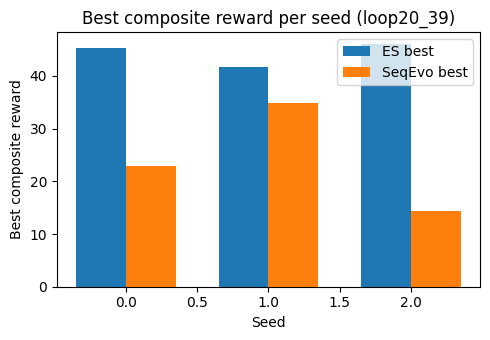

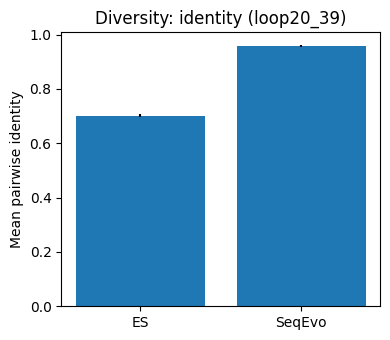

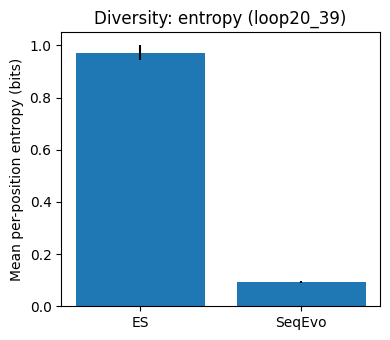


=== Summary for setting: loop10_29 ===
Best reward ES:     49.76 ± 2.28 (n=3)
Best reward SeqEvo: 25.12 ± 6.97 (n=3)
Diversity (identity) ES: 0.705 ± 0.003; SeqEvo: 0.953 ± 0.011
Diversity (entropy)  ES: 0.956 ± 0.029; SeqEvo: 0.099 ± 0.020


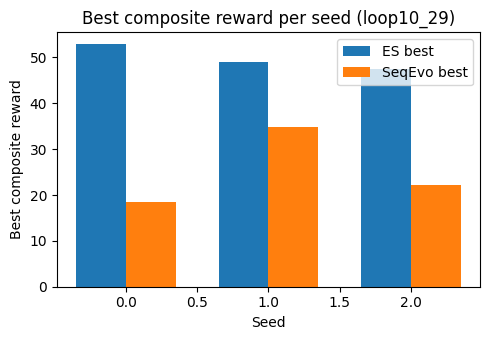

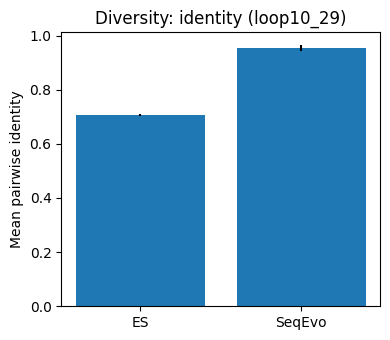

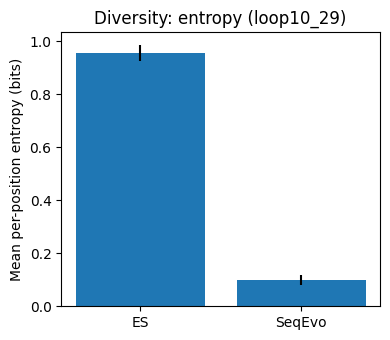


Benchmark finished.
CPU times: user 16min 3s, sys: 8.58 s, total: 16min 11s
Wall time: 16min 54s


In [33]:
%%time
# ============================================================
# Publication-oriented constrained loop benchmark:
#   EGGROLL-style ES vs sequence-space evolution
#   Multi-seed / multi-loop, multi-objective reward
# ============================================================

# -----------------------------
# 0. INSTALL & IMPORTS
# -----------------------------
!pip install -q "fair-esm[esmfold]" biotite einops
!pip install -q 'dllogger @ git+https://github.com/NVIDIA/dllogger.git'
# This may print a wheel build error for openfold on some Colab images
# but is often not strictly required for newer esm versions.
!pip install -q 'openfold @ git+https://github.com/aqlaboratory/openfold.git@4b41059694619831a7db195b7e0988fc4ff3a307' || echo "openfold install failed (may still work)"

import math
import random
from collections import defaultdict
from tempfile import NamedTemporaryFile

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import biotite.structure.io as bsio
import esm
import copy

# Make plots a bit nicer
plt.rcParams["figure.dpi"] = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1. LOAD MODELS (ESM-2 + ESMFold)
# -----------------------------

# ESM-2 (35M) sequence model
lm_model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
lm_model = lm_model.to(device)
lm_model.eval()

AA_LETTERS = list("ACDEFGHIKLMNPQRSTVWY")
AA_INDICES = torch.tensor([alphabet.get_idx(a) for a in AA_LETTERS], device=device)

mask_idx = alphabet.mask_idx
cls_idx = alphabet.cls_idx
eos_idx = alphabet.eos_idx

print("Loaded ESM-2 35M model.")

# ESMFold structure model (black-box oracle)
fold_model = esm.pretrained.esmfold_v1()
fold_model = fold_model.eval().to(device)
fold_model.set_chunk_size(128)

print("Loaded ESMFold v1.")

# -----------------------------
# 2. ESMFold-BASED REWARD (mean pLDDT)
# -----------------------------

@torch.no_grad()
def evaluate_sequence_with_esmfold(
    sequence: str,
    fold_model=fold_model,
    device=device,
) -> float:
    """
    Black-box reward: ESMFold structure prediction + mean pLDDT.
    """
    pdb_str = fold_model.infer_pdb(sequence)

    with NamedTemporaryFile("w+", suffix=".pdb") as tmp:
        tmp.write(pdb_str)
        tmp.flush()
        struct = bsio.load_structure(tmp.name, extra_fields=["b_factor"])

    mean_plddt = float(struct.b_factor.mean())
    return mean_plddt


# -----------------------------
# 3. EGGROLL-STYLE LOW-RANK NOISE FOR ESM-2
# -----------------------------

class EggrollContext:
    def __init__(self, device):
        self.active = False   # turn on/off low-rank noise
        self.rank = 0
        self.sigma = 0.0
        self.thread_id = 0
        self.device = device

egg_ctx = EggrollContext(device)

# Hook Linear layers in lm_model
lin_modules = []  # (name, module, base_key)

for name, module in lm_model.named_modules():
    if isinstance(module, nn.Linear):
        base_key = random.randint(0, 2**31 - 1)
        lin_modules.append((name, module, base_key))
        orig_forward = module.forward

        def make_forward(m, orig, base_key):
            def forward_with_low_rank(x, _orig=orig, _module=m, _base_key=base_key):
                out = _orig(x)
                if egg_ctx.active and _module.weight.ndim == 2:
                    weight = _module.weight
                    out_features, in_features = weight.shape

                    g = torch.Generator(device=egg_ctx.device)
                    combined_seed = (_base_key ^ egg_ctx.thread_id) & 0x7FFFFFFF
                    g.manual_seed(combined_seed)

                    r = egg_ctx.rank
                    if r > 0:
                        perturb = torch.randn(
                            in_features + out_features,
                            r,
                            generator=g,
                            device=egg_ctx.device,
                        )
                        B = perturb[:in_features, :]
                        A = perturb[in_features:, :]

                        adapter = x @ B
                        adapter = adapter @ A.t()
                        out = out + egg_ctx.sigma * adapter / math.sqrt(r)
                return out
            return forward_with_low_rank

        module.forward = make_forward(module, orig_forward, base_key)

print(f"Hooked {len(lin_modules)} Linear modules for EGGROLL-style noise.")

# Map parameters and collect Linear weights
name_to_param = dict(lm_model.named_parameters())
linear_weights = []  # (param_name, param_tensor, base_key)
for name, module, base_key in lin_modules:
    w_name = name + ".weight"
    if w_name in name_to_param:
        linear_weights.append((w_name, name_to_param[w_name], base_key))

print("Number of Linear weight matrices to optimize:", len(linear_weights))

# Save base model state for resetting between experiments
base_state_dict = copy.deepcopy(lm_model.state_dict())
print("Saved base ESM-2 state_dict for resetting.")

# -----------------------------
# 4. ES GRADIENT ESTIMATOR (EGGROLL-STYLE)
# -----------------------------

@torch.no_grad()
def accumulate_linear_grad_buffers(
    grad_buffers,
    linear_weights,
    rank,
    sigma,
    thread_id,
    device,
    weight,
):
    """
    Re-generate the low-rank noise for each Linear weight and accumulate
    weight * sigma * ΔW into grad_buffers[name].
    """
    for param_name, param, base_key in linear_weights:
        out_features, in_features = param.data.shape

        g = torch.Generator(device=device)
        combined_seed = (base_key ^ thread_id) & 0x7FFFFFFF
        g.manual_seed(combined_seed)

        perturb = torch.randn(
            in_features + out_features,
            rank,
            generator=g,
            device=device,
        )
        B = perturb[:in_features, :]     # (in, r)
        A = perturb[in_features:, :]     # (out, r)
        delta = (A @ B.t()) / math.sqrt(rank)  # (out, in)

        if param_name not in grad_buffers:
            grad_buffers[param_name] = torch.zeros_like(param.data)
        grad_buffers[param_name].add_(weight * sigma * delta)


@torch.no_grad()
def es_step_eggroll(
    lm_model,
    linear_weights,
    rank,
    sigma,
    pop_size,
    lr,
    device,
    eval_fn,
    num_sequences,
    seq_length,
    temperature,
):
    """
    One EGGROLL-style ES step:
      - Evaluate pop_size perturbations via low-rank LoRA-like forward
      - Compute normalized rewards
      - Reconstruct perturbations to form a full-rank update
    eval_fn(num_sequences, seq_length, temperature) -> (mean_reward, rewards_list)
    """
    rewards = []

    # 1) Evaluate each population member
    for j in range(pop_size):
        egg_ctx.active = True
        egg_ctx.rank = rank
        egg_ctx.sigma = sigma
        egg_ctx.thread_id = j

        mean_score, _ = eval_fn(
            num_sequences=num_sequences,
            seq_length=seq_length,
            temperature=temperature,
        )
        rewards.append(mean_score)

    egg_ctx.active = False

    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)

    # 2) Normalize rewards
    if rewards_t.std() > 1e-8:
        norm_rewards = (rewards_t - rewards_t.mean()) / (rewards_t.std() + 1e-8)
    else:
        norm_rewards = rewards_t - rewards_t.mean()

    # 3) Accumulate gradient estimate
    grad_buffers = {}
    for j, R in enumerate(norm_rewards):
        accumulate_linear_grad_buffers(
            grad_buffers,
            linear_weights,
            rank=rank,
            sigma=sigma,
            thread_id=j,
            device=device,
            weight=R.item(),
        )

    # 4) Apply update: θ_new = θ + lr * grad_estimate
    scale = lr / (pop_size * (sigma**2 + 1e-8))
    for param_name, param, base_key in linear_weights:
        param.data.add_(scale * grad_buffers[param_name])

    return float(rewards_t.mean().item()), float(rewards_t.max().item()), rewards


# ============================================================
# 5. CONSTRAINED LOOP BENCHMARK (ES vs SeqEvo)
# ============================================================

# -----------------------------
# 5.1 GLOBAL CONFIG
# -----------------------------

SCAFFOLD_SEQ = "KSGISCHGGIWIASFGKHKKRCKAKYERQYVRLIYKNKDKKFSTIKGLWKMIEAEYPDKI"
assert len(SCAFFOLD_SEQ) == 60

CONSTRAINED_SETTINGS = [
    {
        "name": "loop20_39",
        "scaffold": SCAFFOLD_SEQ,
        "mut_start": 20,   # inclusive
        "mut_end": 40,     # exclusive
    },
    {
        "name": "loop10_29",
        "scaffold": SCAFFOLD_SEQ,
        "mut_start": 10,
        "mut_end": 30,
    },
]

# Multi-objective weights
LM_NLL_SCALE = 10.0        # penalty on LM negative log-likelihood per residue
HYDRO_TARGET = 0.45        # target hydrophobic fraction in the loop
HYDRO_SCALE = 80.0
POS_CHARGE_TARGET = 0.35   # K,R,H fraction
NEG_CHARGE_TARGET = 0.35   # D,E fraction
CHARGE_SCALE = 60.0

# ES config (per experiment)
ES_TOTAL_EVALS = 40        # total ESMFold evals per method per seed
ES_POP_SIZE = 4
ES_NUM_SEQ_PER_MEMBER = 2
ES_NUM_STEPS = ES_TOTAL_EVALS // (ES_POP_SIZE * ES_NUM_SEQ_PER_MEMBER)
ES_RANK = 4
ES_SIGMA = 0.02
ES_LR = 0.03
ES_TEMP = 1.0

# Sequence evolution config (per experiment)
SEQEVO_TOTAL_EVALS = ES_TOTAL_EVALS  # match ES
SEQEVO_POP_SIZE = 8
SEQEVO_N_GENERATIONS = SEQEVO_TOTAL_EVALS // SEQEVO_POP_SIZE
SEQEVO_MUT_RATE = 0.05  # per-position in loop

# Which Linear weights to train in ES (subset of `linear_weights`)
NUM_LINEAR_TO_TRAIN = 24
trained_linear_weights_pub = linear_weights[-NUM_LINEAR_TO_TRAIN:]

# Seeds and settings
N_SEEDS = 3   # you can increase for more robustness
BASE_SEED = 4000

print("=== Constrained benchmark CONFIG ===")
print(f"SCAFFOLD_SEQ (L={len(SCAFFOLD_SEQ)}): {SCAFFOLD_SEQ}")
for cfg in CONSTRAINED_SETTINGS:
    print(
        f"  Setting {cfg['name']}: loop {cfg['mut_start']}..{cfg['mut_end']-1} "
        f"(length={cfg['mut_end']-cfg['mut_start']})"
    )
print(f"ES:     evals={ES_TOTAL_EVALS}, steps={ES_NUM_STEPS}, pop={ES_POP_SIZE}, seq/worker={ES_NUM_SEQ_PER_MEMBER}")
print(f"SeqEvo: evals={SEQEVO_TOTAL_EVALS}, gens={SEQEVO_N_GENERATIONS}, pop={SEQEVO_POP_SIZE}")
print(f"ES trains last {NUM_LINEAR_TO_TRAIN} Linear weights out of {len(linear_weights)} total.")

# -----------------------------
# 5.2 BASIC UTILITIES
# -----------------------------

AA_SET = set(AA_LETTERS)
HYDROPHOBIC = set("AILMFWYV")
POSITIVE = set("KRH")
NEGATIVE = set("DE")


def enforce_scaffold_constraint(scaffold: str, loop_seq: str, mut_start: int, mut_end: int) -> str:
    """Return full sequence = scaffold outside [mut_start:mut_end], loop_seq inside."""
    assert len(scaffold) == len(SCAFFOLD_SEQ), "All scaffolds assumed same length here."
    assert mut_end > mut_start
    assert len(loop_seq) == (mut_end - mut_start)
    return scaffold[:mut_start] + loop_seq + scaffold[mut_start + len(loop_seq):]


@torch.no_grad()
def random_loop_from_lm(loop_len: int, temperature: float = 1.0) -> str:
    """Sample a loop of given length from lm_model (independent of scaffold)."""
    from torch.nn import functional as F

    tokens = torch.full(
        (1, loop_len + 2),
        fill_value=mask_idx,
        device=device,
        dtype=torch.long,
    )
    tokens[0, 0] = cls_idx
    tokens[0, -1] = eos_idx

    for pos in range(1, loop_len + 1):
        out = lm_model(tokens, repr_layers=[], return_contacts=False)
        logits = out["logits"][0, pos]
        aa_logits = logits[AA_INDICES]
        probs = F.softmax(aa_logits / temperature, dim=-1)
        aa_idx = torch.multinomial(probs, num_samples=1)
        tok_id = AA_INDICES[aa_idx]
        tokens[0, pos] = tok_id

    seq_tokens = tokens[0, 1:-1].tolist()
    seq = "".join(alphabet.get_tok(t) for t in seq_tokens)
    return seq


def mutate_loop(seq: str, mut_start: int, mut_end: int, mut_rate: float) -> str:
    """Randomly mutate positions within [mut_start:mut_end) with probability mut_rate."""
    loop_len = mut_end - mut_start
    seq_list = list(seq)
    for i in range(loop_len):
        global_pos = mut_start + i
        if random.random() < mut_rate:
            orig = seq_list[global_pos]
            choices = [aa for aa in AA_LETTERS if aa != orig]
            seq_list[global_pos] = random.choice(choices)
    return "".join(seq_list)


def sequence_identity(s1: str, s2: str) -> float:
    assert len(s1) == len(s2)
    return sum(a == b for a, b in zip(s1, s2)) / len(s1)


def mean_pairwise_identity(seqs):
    if len(seqs) < 2:
        return 1.0
    ids = []
    for i in range(len(seqs)):
        for j in range(i + 1, len(seqs)):
            ids.append(sequence_identity(seqs[i], seqs[j]))
    return float(np.mean(ids))


def mean_position_entropy(seqs):
    """Average Shannon entropy (bits) over positions for the set of sequences."""
    if len(seqs) == 0:
        return 0.0
    L = len(seqs[0])
    for s in seqs:
        assert len(s) == L
    entropies = []
    for pos in range(L):
        counts = defaultdict(int)
        for s in seqs:
            counts[s[pos]] += 1
        freqs = np.array([c / len(seqs) for c in counts.values()], dtype=float)
        H = -(freqs * np.log2(freqs + 1e-12)).sum()
        entropies.append(H)
    return float(np.mean(entropies))


# -----------------------------
# 5.3 LM PRIOR & LOOP PENALTIES
# -----------------------------

@torch.no_grad()
def lm_sequence_avg_nll(seq: str) -> float:
    """
    Approximate negative log-likelihood per residue using ESM-2.
    """
    token_ids = [alphabet.get_idx(a) for a in seq]
    tokens = torch.tensor(
        [[cls_idx] + token_ids + [eos_idx]],
        device=device,
        dtype=torch.long,
    )
    out = lm_model(tokens, repr_layers=[], return_contacts=False)
    logits = out["logits"][0, 1:-1]  # (L, vocab)
    log_probs = torch.log_softmax(logits, dim=-1)
    idxs = torch.tensor(token_ids, device=device, dtype=torch.long)
    token_logp = log_probs[torch.arange(len(seq), device=device), idxs]
    avg_nll = float(-token_logp.mean().item())
    return avg_nll


def loop_biophysics_penalty(seq: str, mut_start: int, mut_end: int):
    loop = seq[mut_start:mut_end]
    L = len(loop)
    hyd = sum(aa in HYDROPHOBIC for aa in loop) / L
    pos = sum(aa in POSITIVE for aa in loop) / L
    neg = sum(aa in NEGATIVE for aa in loop) / L

    hyd_pen = HYDRO_SCALE * max(0.0, hyd - HYDRO_TARGET) ** 2
    pos_pen = CHARGE_SCALE * max(0.0, pos - POS_CHARGE_TARGET) ** 2
    neg_pen = CHARGE_SCALE * max(0.0, neg - NEG_CHARGE_TARGET) ** 2
    total_pen = hyd_pen + pos_pen + neg_pen
    comps = {
        "hydrophobic_frac": hyd,
        "pos_frac": pos,
        "neg_frac": neg,
        "hyd_pen": hyd_pen,
        "pos_pen": pos_pen,
        "neg_pen": neg_pen,
    }
    return total_pen, comps


# -----------------------------
# 5.4 MULTI-OBJECTIVE REWARD
# -----------------------------

@torch.no_grad()
def evaluate_sequence_multiobjective(
    full_seq: str,
    mut_start: int,
    mut_end: int,
):
    """
    Components:
      - + mean pLDDT (ESMFold)
      - - LM_NLL_SCALE * avg NLL (ESM-2 pseudo-likelihood)
      - - loop biophysics penalty (hydrophobicity / charge)
    """
    mean_plddt = evaluate_sequence_with_esmfold(full_seq)
    avg_nll = lm_sequence_avg_nll(full_seq)
    lm_penalty = LM_NLL_SCALE * avg_nll
    loop_penalty, loop_comps = loop_biophysics_penalty(full_seq, mut_start, mut_end)

    reward = mean_plddt - lm_penalty - loop_penalty

    comps = {
        "plddt": mean_plddt,
        "avg_nll": avg_nll,
        "lm_penalty": lm_penalty,
        "loop_penalty": loop_penalty,
    }
    comps.update(loop_comps)
    return reward, comps


# -----------------------------
# 5.5 ES EXPERIMENT
# -----------------------------

def es_constrained_eval_once(
    scaffold_cfg,
    num_sequences: int,
    temperature: float,
):
    mut_start = scaffold_cfg["mut_start"]
    mut_end = scaffold_cfg["mut_end"]
    loop_len = mut_end - mut_start
    scaffold = scaffold_cfg["scaffold"]

    rewards = []
    for _ in range(num_sequences):
        loop_seq = random_loop_from_lm(loop_len, temperature=temperature)
        full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)
        r, _ = evaluate_sequence_multiobjective(full_seq, mut_start, mut_end)
        rewards.append(r)
    return float(np.mean(rewards)), rewards


def run_es_constrained_single(
    scaffold_cfg,
    seed: int,
):
    print("\n==============================")
    print(f"ES constrained run: setting={scaffold_cfg['name']} seed={seed}")
    print("==============================")

    # Reset model weights for a clean run
    lm_model.load_state_dict(base_state_dict)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    history = []
    best_reward = -1e9

    # IMPORTANT FIX: parameter name must be `seq_length` to match es_step_eggroll call
    def eval_fn(num_sequences, seq_length, temperature):
        avg_r, rewards = es_constrained_eval_once(
            scaffold_cfg,
            num_sequences=num_sequences,
            temperature=temperature,
        )
        return avg_r, rewards

    for step in range(1, ES_NUM_STEPS + 1):
        avg_r, max_r, all_r = es_step_eggroll(
            lm_model,
            trained_linear_weights_pub,
            rank=ES_RANK,
            sigma=ES_SIGMA,
            pop_size=ES_POP_SIZE,
            lr=ES_LR,
            device=device,
            eval_fn=eval_fn,
            num_sequences=ES_NUM_SEQ_PER_MEMBER,
            seq_length=len(scaffold_cfg["scaffold"]),
            temperature=ES_TEMP,
        )
        history.append((avg_r, max_r))
        print(f"[ES {scaffold_cfg['name']} | step {step:02d}] avg={avg_r:.2f}, max={max_r:.2f}")

        if max_r > best_reward:
            best_reward = max_r

    # Diversity from final ES-updated model
    mut_start = scaffold_cfg["mut_start"]
    mut_end = scaffold_cfg["mut_end"]
    loop_len = mut_end - mut_start
    scaffold = scaffold_cfg["scaffold"]
    final_samples = []
    with torch.no_grad():
        for _ in range(ES_POP_SIZE * ES_NUM_SEQ_PER_MEMBER * 2):
            loop_seq = random_loop_from_lm(loop_len, temperature=ES_TEMP)
            full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)
            final_samples.append(full_seq)

    div_identity = mean_pairwise_identity(final_samples)
    div_entropy = mean_position_entropy(final_samples)
    print(
        f"[ES diversity] n={len(final_samples)}, "
        f"mean identity={div_identity:.3f}, mean entropy={div_entropy:.3f}"
    )

    return {
        "history": history,
        "best_reward": best_reward,
        "final_samples": final_samples,
        "div_identity": div_identity,
        "div_entropy": div_entropy,
    }


# -----------------------------
# 5.6 SEQUENCE-SPACE EVOLUTION EXPERIMENT
# -----------------------------

def run_seqevo_constrained_single(
    scaffold_cfg,
    seed: int,
):
    print("\n=== SeqEvo constrained run: setting={} seed={} ===".format(scaffold_cfg["name"], seed))

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    mut_start = scaffold_cfg["mut_start"]
    mut_end = scaffold_cfg["mut_end"]
    loop_len = mut_end - mut_start
    scaffold = scaffold_cfg["scaffold"]

    # Initialize population
    population = []
    for _ in range(SEQEVO_POP_SIZE):
        loop_seq = random_loop_from_lm(loop_len, temperature=ES_TEMP)
        full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)
        population.append(full_seq)

    history = []
    best_reward = -1e9
    best_seq = None

    for gen in range(SEQEVO_N_GENERATIONS):
        rewards = []
        pl_ddts = []
        for seq in population:
            r, comps = evaluate_sequence_multiobjective(seq, mut_start, mut_end)
            rewards.append(r)
            pl_ddts.append(comps["plddt"])
        rewards = np.array(rewards, dtype=float)
        history.append((float(rewards.mean()), float(rewards.max())))
        print(
            f"[SeqEvo {scaffold_cfg['name']} | gen {gen:02d}] "
            f"avg={rewards.mean():.2f}, max={rewards.max():.2f}, avg_pLDDT={np.mean(pl_ddts):.2f}"
        )

        max_idx = int(rewards.argmax())
        if rewards[max_idx] > best_reward:
            best_reward = float(rewards[max_idx])
            best_seq = population[max_idx]

        # Selection + mutation
        parent_indices = rewards.argsort()[::-1][: max(2, SEQEVO_POP_SIZE // 4)]
        parents = [population[i] for i in parent_indices]

        new_population = []
        while len(new_population) < SEQEVO_POP_SIZE:
            parent = random.choice(parents)
            child = mutate_loop(parent, mut_start, mut_end, SEQEVO_MUT_RATE)
            new_population.append(child)
        population = new_population

    div_identity = mean_pairwise_identity(population)
    div_entropy = mean_position_entropy(population)
    print(
        f"[SeqEvo diversity] n={len(population)}, "
        f"mean identity={div_identity:.3f}, mean entropy={div_entropy:.3f}"
    )

    return {
        "history": history,
        "best_reward": best_reward,
        "best_seq": best_seq,
        "final_population": population,
        "div_identity": div_identity,
        "div_entropy": div_entropy,
    }


# -----------------------------
# 5.7 FULL BENCHMARK + PLOTS
# -----------------------------

def run_full_constrained_benchmark():
    all_results = {
        "ES": defaultdict(list),
        "SeqEvo": defaultdict(list),
    }

    for cfg in CONSTRAINED_SETTINGS:
        for s in range(N_SEEDS):
            es_seed = BASE_SEED + s
            seq_seed = BASE_SEED + 1000 + s

            es_res = run_es_constrained_single(cfg, es_seed)
            se_res = run_seqevo_constrained_single(cfg, seq_seed)

            all_results["ES"][cfg["name"]].append(es_res)
            all_results["SeqEvo"][cfg["name"]].append(se_res)

    # Aggregate
    for cfg in CONSTRAINED_SETTINGS:
        name = cfg["name"]
        es_runs = all_results["ES"][name]
        se_runs = all_results["SeqEvo"][name]

        es_best = np.array([r["best_reward"] for r in es_runs], dtype=float)
        se_best = np.array([r["best_reward"] for r in se_runs], dtype=float)

        es_id = np.array([r["div_identity"] for r in es_runs], dtype=float)
        se_id = np.array([r["div_identity"] for r in se_runs], dtype=float)
        es_ent = np.array([r["div_entropy"] for r in es_runs], dtype=float)
        se_ent = np.array([r["div_entropy"] for r in se_runs], dtype=float)

        print("\n=== Summary for setting:", name, "===")
        print(
            f"Best reward ES:     {es_best.mean():.2f} ± {es_best.std():.2f} "
            f"(n={len(es_best)})"
        )
        print(
            f"Best reward SeqEvo: {se_best.mean():.2f} ± {se_best.std():.2f} "
            f"(n={len(se_best)})"
        )
        print(
            f"Diversity (identity) ES: {es_id.mean():.3f} ± {es_id.std():.3f}; "
            f"SeqEvo: {se_id.mean():.3f} ± {se_id.std():.3f}"
        )
        print(
            f"Diversity (entropy)  ES: {es_ent.mean():.3f} ± {es_ent.std():.3f}; "
            f"SeqEvo: {se_ent.mean():.3f} ± {se_ent.std():.3f}"
        )

        # Best reward per seed
        seeds = np.arange(len(es_best))
        width = 0.35
        plt.figure(figsize=(5, 3.5))
        plt.bar(seeds - width / 2, es_best, width, label="ES best")
        plt.bar(seeds + width / 2, se_best, width, label="SeqEvo best")
        plt.xlabel("Seed")
        plt.ylabel("Best composite reward")
        plt.title(f"Best composite reward per seed ({name})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Diversity plots
        plt.figure(figsize=(4, 3.5))
        plt.bar([0, 1], [es_id.mean(), se_id.mean()], yerr=[es_id.std(), se_id.std()])
        plt.xticks([0, 1], ["ES", "SeqEvo"])
        plt.ylabel("Mean pairwise identity")
        plt.title(f"Diversity: identity ({name})")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(4, 3.5))
        plt.bar([0, 1], [es_ent.mean(), se_ent.mean()], yerr=[es_ent.std(), se_ent.std()])
        plt.xticks([0, 1], ["ES", "SeqEvo"])
        plt.ylabel("Mean per-position entropy (bits)")
        plt.title(f"Diversity: entropy ({name})")
        plt.tight_layout()
        plt.show()

    return all_results


# -----------------------------
# 5.8 RUN THE BENCHMARK
# -----------------------------

full_results = run_full_constrained_benchmark()
print("\nBenchmark finished.")

In [ ]:
%%time
# ============================================================
# Extended publication-oriented benchmark:
#   + RL (REINFORCE) baseline in sequence space
#   + Best-of-N sampling baseline
#   Reuses:
#     - lm_model, fold_model, device
#     - ES configs, ES vs SeqEvo constrained benchmark
#     - evaluate_sequence_multiobjective, enforce_scaffold_constraint,
#       random_loop_from_lm, mean_pairwise_identity, mean_position_entropy
# ============================================================

import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# -----------------------------
# 1. CONFIG FOR NEW BASELINES
# -----------------------------

# RL baseline: sequence-space REINFORCE over loop positions
RL_TOTAL_EVALS = ES_TOTAL_EVALS          # match ESMFold budget with ES
RL_EPISODES = RL_TOTAL_EVALS            # 1 oracle call per episode
RL_LR = 0.1                             # learning rate for policy biases
RL_BASELINE_MOMENTUM = 0.9              # moving-average baseline
RL_TEMP = 1.0                           # sampling temperature

# Best-of-N baseline: sample from frozen LM
BESTOF_TOTAL_EVALS = ES_TOTAL_EVALS     # match oracle budget
BESTOF_TEMP = 1.0

# Seed offsets (to avoid overlap with ES / SeqEvo seeds)
RL_SEED_OFFSET = 2000
BESTOF_SEED_OFFSET = 3000

print("=== Extended baseline CONFIG ===")
print(f"RL episodes per run:         {RL_EPISODES}")
print(f"Best-of-N evals per run:     {BESTOF_TOTAL_EVALS}")
print(f"Seed offsets: RL={RL_SEED_OFFSET}, BestOf={BESTOF_SEED_OFFSET}")

# -----------------------------
# 2. RL POLICY UTILITIES
# -----------------------------

def _set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

@torch.no_grad()
def _lm_logits_for_step(tokens, pos: int):
    """
    Helper: single forward through lm_model at a given position,
    returning logits over the 20 standard AAs.
    """
    out = lm_model(tokens, repr_layers=[], return_contacts=False)
    logits = out["logits"][0, pos]            # (vocab,)
    aa_logits = logits[AA_INDICES]           # (20,)
    return aa_logits.detach()                # detach: no grad through LM


def sample_loop_from_policy(loop_len: int,
                            policy_bias: torch.Tensor,
                            temperature: float = 1.0):
    """
    Sample a loop of length `loop_len` from a policy that starts from LM logits
    and adds a per-position bias (trainable).
    Returns:
      - loop sequence (string of length loop_len)
      - sum of log-probs (torch scalar) for REINFORCE.
    """
    assert policy_bias.shape == (loop_len, len(AA_LETTERS))

    tokens = torch.full(
        (1, loop_len + 2),
        fill_value=mask_idx,
        device=device,
        dtype=torch.long,
    )
    tokens[0, 0] = cls_idx
    tokens[0, -1] = eos_idx

    logprob_terms = []

    for pos in range(1, loop_len + 1):
        # LM logits for current context (no grad through LM)
        aa_logits = _lm_logits_for_step(tokens, pos)  # (20,)

        # Add trainable bias and apply temperature
        biased_logits = aa_logits / temperature + policy_bias[pos - 1]  # (20,)
        dist = torch.distributions.Categorical(logits=biased_logits)
        aa_idx = dist.sample()
        logprob_terms.append(dist.log_prob(aa_idx))

        tok_id = AA_INDICES[aa_idx]
        tokens[0, pos] = tok_id

    logprob_sum = torch.stack(logprob_terms).sum()
    seq_tokens = tokens[0, 1:-1].tolist()
    seq = "".join(alphabet.get_tok(t) for t in seq_tokens)
    return seq, logprob_sum


def run_rl_constrained_single(scaffold_cfg, seed: int):
    """
    REINFORCE baseline:
      - Train a per-position bias on top of LM logits for the loop region.
      - Reward = multi-objective composite (same as ES & SeqEvo).
      - Uses RL_TOTAL_EVALS episodes / oracle calls.
    Returns:
      - history of rewards
      - best_reward, best_seq
      - diversity metrics from final policy samples
    """
    print("\n==============================")
    print(f"RL constrained run: setting={scaffold_cfg['name']} seed={seed}")
    print("==============================")

    _set_all_seeds(seed)

    mut_start = scaffold_cfg["mut_start"]
    mut_end = scaffold_cfg["mut_end"]
    loop_len = mut_end - mut_start
    scaffold = scaffold_cfg["scaffold"]

    # Policy parameters: per-position bias over 20 AAs (init ~0 => LM)
    policy_bias = torch.zeros(loop_len, len(AA_LETTERS), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([policy_bias], lr=RL_LR)

    baseline = None  # moving-average reward baseline
    best_reward = -1e9
    best_seq = None
    rewards_history = []

    for ep in range(RL_EPISODES):
        optimizer.zero_grad()

        loop_seq, logprob_sum = sample_loop_from_policy(loop_len, policy_bias, RL_TEMP)
        full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)

        R, comps = evaluate_sequence_multiobjective(full_seq, mut_start, mut_end)
        rewards_history.append(R)

        # Update baseline
        if baseline is None:
            baseline = R
        else:
            baseline = RL_BASELINE_MOMENTUM * baseline + (1.0 - RL_BASELINE_MOMENTUM) * R

        # REINFORCE loss
        advantage = torch.tensor(R - baseline, device=device, dtype=torch.float32)
        loss = -advantage * logprob_sum
        loss.backward()
        optimizer.step()

        if R > best_reward:
            best_reward = R
            best_seq = full_seq

        if (ep + 1) % 5 == 0 or ep == 0:
            print(
                f"[RL {scaffold_cfg['name']} | ep {ep+1:02d}] "
                f"reward={R:.2f}, best={best_reward:.2f}, baseline={baseline:.2f}"
            )

    # Diversity from final policy
    final_samples = []
    with torch.no_grad():
        for _ in range(SEQEVO_POP_SIZE * 2):  # modest sample for diversity
            loop_seq, _ = sample_loop_from_policy(loop_len, policy_bias, RL_TEMP)
            full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)
            final_samples.append(full_seq)

    div_identity = mean_pairwise_identity(final_samples)
    div_entropy = mean_position_entropy(final_samples)
    print(
        f"[RL diversity] n={len(final_samples)}, "
        f"mean identity={div_identity:.3f}, mean entropy={div_entropy:.3f}"
    )

    return {
        "history": rewards_history,
        "best_reward": best_reward,
        "best_seq": best_seq,
        "final_samples": final_samples,
        "div_identity": div_identity,
        "div_entropy": div_entropy,
    }


# -----------------------------
# 3. BEST-OF-N SAMPLING BASELINE
# -----------------------------

def run_bestof_constrained_single(scaffold_cfg, seed: int):
    """
    Best-of-N baseline:
      - Sample BESTOF_TOTAL_EVALS loops from frozen LM
      - Evaluate composite reward and keep the best
      - Diversity over all sampled sequences
    """
    print("\n==============================")
    print(f"Best-of-N constrained run: setting={scaffold_cfg['name']} seed={seed}")
    print("==============================")

    _set_all_seeds(seed)

    mut_start = scaffold_cfg["mut_start"]
    mut_end = scaffold_cfg["mut_end"]
    loop_len = mut_end - mut_start
    scaffold = scaffold_cfg["scaffold"]

    best_reward = -1e9
    best_seq = None
    all_rewards = []
    all_seqs = []

    for i in range(BESTOF_TOTAL_EVALS):
        loop_seq = random_loop_from_lm(loop_len, temperature=BESTOF_TEMP)
        full_seq = enforce_scaffold_constraint(scaffold, loop_seq, mut_start, mut_end)
        R, _ = evaluate_sequence_multiobjective(full_seq, mut_start, mut_end)

        all_rewards.append(R)
        all_seqs.append(full_seq)

        if R > best_reward:
            best_reward = R
            best_seq = full_seq

        if (i + 1) % 5 == 0 or i == 0:
            print(
                f"[BestOf {scaffold_cfg['name']} | sample {i+1:02d}] "
                f"reward={R:.2f}, best={best_reward:.2f}"
            )

    div_identity = mean_pairwise_identity(all_seqs)
    div_entropy = mean_position_entropy(all_seqs)
    print(
        f"[BestOf diversity] n={len(all_seqs)}, "
        f"mean identity={div_identity:.3f}, mean entropy={div_entropy:.3f}"
    )

    return {
        "history": all_rewards,
        "best_reward": best_reward,
        "best_seq": best_seq,
        "all_seqs": all_seqs,
        "div_identity": div_identity,
        "div_entropy": div_entropy,
    }


# -----------------------------
# 4. RUN NEW BASELINES (RL + BestOf)
# -----------------------------

def run_extended_baselines():
    """
    For each constrained setting and seed:
      - run RL baseline
      - run Best-of-N baseline
    Returns:
      rl_results[name]  -> list of per-seed dicts
      bestof_results[name] -> list of per-seed dicts
    """
    rl_results = defaultdict(list)
    bestof_results = defaultdict(list)

    for cfg in CONSTRAINED_SETTINGS:
        for s in range(N_SEEDS):
            rl_seed = BASE_SEED + RL_SEED_OFFSET + s
            bo_seed = BASE_SEED + BESTOF_SEED_OFFSET + s

            rl_res = run_rl_constrained_single(cfg, rl_seed)
            bo_res = run_bestof_constrained_single(cfg, bo_seed)

            rl_results[cfg["name"]].append(rl_res)
            bestof_results[cfg["name"]].append(bo_res)

    return rl_results, bestof_results


rl_results, bestof_results = run_extended_baselines()
print("\nFinished RL + Best-of-N baselines.")

# -----------------------------
# 5. COMBINED SUMMARY (ES, SeqEvo, RL, BestOf)
# -----------------------------

def summarize_all_methods(full_results, rl_results, bestof_results):
    """
    Combine ES / SeqEvo (from `full_results`) with RL and Best-of-N baselines,
    summarizing best reward and diversity across seeds for each loop setting.
    """
    methods = ["ES", "SeqEvo", "RL", "BestOf"]

    for cfg in CONSTRAINED_SETTINGS:
        name = cfg["name"]
        print("\n" + "=" * 70)
        print(f"Extended summary for setting: {name}")
        print("=" * 70)

        es_runs = full_results["ES"][name]
        se_runs = full_results["SeqEvo"][name]
        rl_runs = rl_results[name]
        bo_runs = bestof_results[name]

        method_best = {
            "ES":      np.array([r["best_reward"] for r in es_runs], dtype=float),
            "SeqEvo":  np.array([r["best_reward"] for r in se_runs], dtype=float),
            "RL":      np.array([r["best_reward"] for r in rl_runs], dtype=float),
            "BestOf":  np.array([r["best_reward"] for r in bo_runs], dtype=float),
        }

        method_id = {
            "ES":      np.array([r["div_identity"] for r in es_runs], dtype=float),
            "SeqEvo":  np.array([r["div_identity"] for r in se_runs], dtype=float),
            "RL":      np.array([r["div_identity"] for r in rl_runs], dtype=float),
            "BestOf":  np.array([r["div_identity"] for r in bo_runs], dtype=float),
        }

        method_ent = {
            "ES":      np.array([r["div_entropy"] for r in es_runs], dtype=float),
            "SeqEvo":  np.array([r["div_entropy"] for r in se_runs], dtype=float),
            "RL":      np.array([r["div_entropy"] for r in rl_runs], dtype=float),
            "BestOf":  np.array([r["div_entropy"] for r in bo_runs], dtype=float),
        }

        # Text summary
        for m in methods:
            arr = method_best[m]
            print(f"{m:7s} best reward: {arr.mean():6.2f} ± {arr.std():5.2f}  (n={len(arr)})")
        for m in methods:
            arr = method_id[m]
            print(f"{m:7s} mean pairwise identity: {arr.mean():5.3f} ± {arr.std():5.3f}")
        for m in methods:
            arr = method_ent[m]
            print(f"{m:7s} mean per-pos entropy:   {arr.mean():5.3f} ± {arr.std():5.3f}")

        # Plots: best reward per method (mean ± std)
        means = [method_best[m].mean() for m in methods]
        stds  = [method_best[m].std() for m in methods]
        x = np.arange(len(methods))

        plt.figure(figsize=(6, 4))
        plt.bar(x, means, yerr=stds)
        plt.xticks(x, methods)
        plt.ylabel("Best composite reward")
        plt.title(f"Best composite reward across seeds ({name})")
        plt.tight_layout()
        plt.show()

        # Diversity: identity
        id_means = [method_id[m].mean() for m in methods]
        id_stds  = [method_id[m].std() for m in methods]
        plt.figure(figsize=(6, 4))
        plt.bar(x, id_means, yerr=id_stds)
        plt.xticks(x, methods)
        plt.ylabel("Mean pairwise identity")
        plt.title(f"Diversity: identity across seeds ({name})")
        plt.tight_layout()
        plt.show()

        # Diversity: entropy
        ent_means = [method_ent[m].mean() for m in methods]
        ent_stds  = [method_ent[m].std() for m in methods]
        plt.figure(figsize=(6, 4))
        plt.bar(x, ent_means, yerr=ent_stds)
        plt.xticks(x, methods)
        plt.ylabel("Mean per-position entropy (bits)")
        plt.title(f"Diversity: entropy across seeds ({name})")
        plt.tight_layout()
        plt.show()


summarize_all_methods(full_results, rl_results, bestof_results)
print("\nExtended benchmark (ES + SeqEvo + RL + BestOf) completed.")

=== Extended baseline CONFIG ===
RL episodes per run:         40
Best-of-N evals per run:     40
Seed offsets: RL=2000, BestOf=3000

RL constrained run: setting=loop20_39 seed=6000
[RL loop20_39 | ep 01] reward=8.13, best=8.13, baseline=8.13
[RL loop20_39 | ep 05] reward=17.41, best=17.41, baseline=9.64
[RL loop20_39 | ep 10] reward=11.91, best=18.81, baseline=10.36
[RL loop20_39 | ep 15] reward=3.07, best=19.39, baseline=9.76
[RL loop20_39 | ep 20] reward=8.34, best=22.92, baseline=10.82
[RL loop20_39 | ep 25] reward=4.43, best=22.92, baseline=10.48
[RL loop20_39 | ep 30] reward=4.66, best=22.92, baseline=9.70
[RL loop20_39 | ep 35] reward=4.66, best=22.92, baseline=10.26
[RL loop20_39 | ep 40] reward=3.68, best=22.92, baseline=9.09
[RL diversity] n=16, mean identity=0.729, mean entropy=0.826

Best-of-N constrained run: setting=loop20_39 seed=7000
[BestOf loop20_39 | sample 01] reward=7.79, best=7.79
[BestOf loop20_39 | sample 05] reward=7.02, best=14.48
[BestOf loop20_39 | sample 10]